In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

# `Contents`
---
1. [Setup](#setup)
1. [Extracting DataFrames from SQLite](#df_setup)
1. [Trade Analysis](#problem)
1. [PnL Calculation Explained Step-By-Step](#pnl)
1. [Question 1](#q1)
    1. [Solution / Code](#s1)
    1. [Answer 1](#a1)
1. [Question 2](#q2)
    1. [Solution / Code](#s2)
    1. [Answer 2](#a2)
    1. [(Possibly) Interesting Insight: Why Bad Stocks Are Doing Badly?](#insight)
1. [Question 3](#q3)
    1. [Solution / Code](#s3)
    1. [Answer 3](#a3)
1. [Scope for Further Analysis and Improvement](#scope)
1. [Glossary](#glossary)

<a id='setup'></a>
# 1. `Setup`
---
Fetch the data files from `Amazon S3`.

In [2]:
# shell command to remove files with name 'trading' from current directory (if any)
!rm trading.*

# We get the files from AWS
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/1754rb8ahse/2fb472d3a84ab819ccb047a90d0ae0ee/trading.zip.001'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/1754rb8ahse/123ab2dff1249f69a2e84cc8cb18e875/trading.zip.002'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/1754rb8ahse/bccd463803c67208c3d929b88260a1e9/trading.zip.003'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/1754rb8ahse/781a32d72b6e03bbfbc1c6debcee2503/trading.zip.004'
!wget 'https://hr-projects-assets-prod.s3.amazonaws.com/1754rb8ahse/112c3420755cd1c072f5c32d835e3f15/trading.zip.005'

# We create the correct zip file
!cat trading.zip.* > trading.zip

# We unpack the archive
from shutil import unpack_archive
unpack_archive('trading.zip', '.')

--2023-01-01 22:28:16--  https://hr-projects-assets-prod.s3.amazonaws.com/1754rb8ahse/2fb472d3a84ab819ccb047a90d0ae0ee/trading.zip.001
Resolving hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)... 54.231.164.97, 54.231.196.73, 54.231.136.145, ...
Connecting to hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)|54.231.164.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99614720 (95M) [binary/octet-stream]
Saving to: 'trading.zip.001'

trading.zip.001     100%[===================>]  95.00M  6.32MB/s    in 14s     

2023-01-01 22:28:31 (6.70 MB/s) - 'trading.zip.001' saved [99614720/99614720]

--2023-01-01 22:28:31--  https://hr-projects-assets-prod.s3.amazonaws.com/1754rb8ahse/123ab2dff1249f69a2e84cc8cb18e875/trading.zip.002
Resolving hr-projects-assets-prod.s3.amazonaws.com (hr-projects-assets-prod.s3.amazonaws.com)... 52.216.200.27, 52.217.17.140, 52.217.106.236, ...
Connecting to hr-projec

<a id='df_setup'></a>
# 2. `Extracting DataFrames from SQLite`
---

> ##### Extract tables as `DataFrames` from `SQLite DB` via `sqlite3` and `pandas`

In [3]:
# The database is a SQLite DB
import sqlite3

connection = sqlite3.connect("trading.db")
cursor = connection.cursor()

tables = cursor.execute("SELECT name FROM sqlite_master")
tables.fetchall()

[('instruments',),
 ('fx_rates',),
 ('market_data',),
 ('theoretical_prices',),
 ('market_transactions',),
 ('optiver_transactions',)]

##### `instruments table`

In [4]:
instruments_df = pd.read_sql_query(sql = "SELECT * FROM instruments", 
                                   con = connection, 
                                   index_col = 'instrument_id')

instruments_df.head()

index   mic          isin currency ticker                name  \
instrument_id                                                                  
0                  0  CEUX  FR0010193979      EUR  CBOTP      CBo Territoria   
1                  1  XGAT  DE0001262152      EUR   DTD2  B+S Banksysteme AG   
2                  2  CEUX  IT0004729759      EUR   SESM            Sesa SpA   
3                  3  MUND  US0036541003      USD    AIO         ABIOMED Inc   
4                  4  TRQX  BE0974258874      EUR  BEKBB          Bekaert SA   

              country         industry_subgroup  
instrument_id                                    
0                  FR  Real Estate Mgmnt/Servic  
1                  GE     Applications Software  
2                  IT  Electronic Parts Distrib  
3                  US          Medical Products  
4                  BE       Wire&Cable Products

##### `fx_rates table`

In [5]:
fx_rates_df = pd.read_sql_query(sql = "SELECT * FROM fx_rates",
                                con = connection, 
                                index_col = 'currency')

fx_rates_df.head()

index  fx_rate
currency                
AED           0     4.15
AUD           1     1.57
BDT           2    96.85
BHD           3     0.43
BRL           4     6.42

##### `market_data table`

In [6]:
%%time

market_data_df = pd.read_sql_query(sql = "SELECT * FROM market_data", 
                                   con = connection, 
                                   index_col = ['instrument_id', 'timestamp'],
                                   parse_dates = ['timestamp'])

market_data_df

CPU times: user 46.3 s, sys: 18.6 s, total: 1min 4s
Wall time: 1min 13s


index  bid_size  bid_price  \
instrument_id timestamp                                                 
2             2021-01-02 09:00:00.000000       0    100.00      19.34   
              2021-01-02 09:00:17.099670       1    100.00      19.34   
              2021-01-02 09:01:06.363591       2  36993.00      19.35   
              2021-01-02 09:01:16.607528       3   9770.00      19.34   
              2021-01-02 09:01:48.942755       4   5330.00      19.33   
...                                          ...       ...        ...   
489           2021-09-30 17:27:16.351293  199031   1121.00     460.01   
              2021-09-30 17:27:44.506969  199032    100.00     460.13   
              2021-09-30 17:28:29.092499  199033    100.00     459.96   
              2021-09-30 17:28:55.588657  199034    100.00     459.98   
              2021-09-30 17:29:33.567841  199035    100.00     459.97   

                                          ask_price  ask_size  
instrument_id timestamp                                        
2             2021-01-02 09:00:00.000000      19.35    583.00  
              2021-01-02 09:00:17.099670      19.35    100.00  
              2021-01-02 09:01:06.363591      19.36  11208.00  
              2021-01-02 09:01:16.607528      19.35   6231.00  
              2021-01-02 09:01:48.942755      19.34   2671.00  
...                                             ...       ...  
489           2021-09-30 17:27:16.351293     460.02    780.00  
              2021-09-30 17:27:44.506969     460.14    100.00  
              2021-09-30 17:28:29.092499     459.97    100.00  
              2021-09-30 17:28:55.588657     459.99    100.00  
              2021-09-30 17:29:33.567841     459.98    100.00  

[9950975 rows x 5 columns]

##### `theoretical_prices table`

In [7]:
theoretical_prices_df = pd.read_sql_query(sql = "SELECT * FROM theoretical_prices", 
                                          con = connection, 
                                          index_col = ['instrument_id', 'timestamp'],
                                          parse_dates = ['timestamp'])

theoretical_prices_df

index   theo
instrument_id timestamp                                
2             2021-01-02 09:00:00.000000       0  19.35
              2021-01-02 09:00:17.099670       1  19.35
              2021-01-02 09:01:06.363591       2  19.35
              2021-01-02 09:01:16.607528       3  19.34
              2021-01-02 09:01:48.942755       4  19.33
...                                          ...    ...
489           2021-09-30 17:27:16.351293  199031 460.01
              2021-09-30 17:27:44.506969  199032 460.13
              2021-09-30 17:28:29.092499  199033 459.97
              2021-09-30 17:28:55.588657  199034 459.99
              2021-09-30 17:29:33.567841  199035 459.98

[9950975 rows x 2 columns]

##### `market_transactions table`

In [8]:
market_transactions_df = pd.read_sql_query(sql = "SELECT * FROM market_transactions", 
                                           con = connection,
                                           index_col = ['instrument_id', 'timestamp'], 
                                           parse_dates = ['timestamp'])

market_transactions_df

index    size  price
instrument_id timestamp                                       
2             2021-01-02 09:01:48.942755      0  425024  19.33
              2021-01-02 09:02:13.558322      1  425024  19.33
              2021-01-02 09:02:57.927130      2  425024  19.33
              2021-01-02 09:04:19.475209      3  425024  19.34
              2021-01-02 09:06:12.054161      4  425024  19.33
...                                         ...     ...    ...
489           2021-09-30 17:23:00.271374  88450  426960 459.71
              2021-09-30 17:23:38.264907  88451  426960 459.61
              2021-09-30 17:25:54.703249  88452  426960 460.04
              2021-09-30 17:26:48.685813  88453  426960 459.92
              2021-09-30 17:29:33.567841  88454  426960 459.98

[3169892 rows x 3 columns]

##### `firm_transactions table`

In [9]:
firm_transactions_df = pd.read_sql_query(sql = "SELECT * FROM optiver_transactions", 
                                         con = connection, 
                                         index_col = ['instrument_id', 'timestamp'], 
                                         parse_dates = ['timestamp'])

firm_transactions_df

index     size  price
instrument_id timestamp                                        
2             2021-01-02 09:02:13.558322      0   -61.00  19.33
              2021-01-02 09:06:12.054161      1 -1116.00  19.33
              2021-01-02 09:07:16.332669      2  3465.00  19.34
              2021-01-02 09:11:29.017237      3    49.00  19.37
              2021-01-02 09:13:16.004471      4 -4694.00  19.37
...                                         ...      ...    ...
489           2021-09-30 17:17:30.927683  39285    86.00 459.06
              2021-09-30 17:19:21.131996  39286   623.00 459.39
              2021-09-30 17:23:00.271374  39287   -67.00 459.71
              2021-09-30 17:23:38.264907  39288   -66.00 459.61
              2021-09-30 17:25:54.703249  39289   -63.00 460.04

[701948 rows x 3 columns]

In [10]:
connection.close()

<a id='problem'></a>
# 3. `Trade Analysis`
---
For each of the listing (`instruments` table) we trade, we have the following data:
1.	Market updates (`market_data` table) i.e. top of the order book only with volumes and prices
2.	Theoretical prices (`theoretical_prices` table) at each market update
3.	Transactions that happened in the market (`market_transactions` table)
4.	Our transactions (`firm_transactions` table), transactions that happened in the market and were done by us 

All the data is autogenerated / made-up. We have also included the FX rates that should be used (`fx_rates` table).

##### `Problem Statement`

Two traders are running their portfolios. Each runs its own set of strategies. We would like to know which trader is performing the best and how sure are we about that evaluation.
* Trader A runs strategies on stocks with the following instrument_ids (34, 54, 62, 72, 73, 84, 93, 146, 161)
* Trader B runs strategies on stocks with following instrument_ids (214, 218, 231, 237, 239, 264, 266, 275, 292)

We evaluate the performance using the profit and loss (`PnL`). We calculate this profit and loss using the following formula.

$$PnL_{pos} = \left( \sum_{i}^{history} v_i \right) (p_n - p_k)$$
$$PnL_{trad} = -\sum_{i}^{today} v_i p_i + \left( \sum_{i}^{today} v_i \right) p_n$$

where 
* $v_i$ is the volume of trade with index i
* $p_i$ is the price of trade i
* $p_n$ is the last trade price in the stock
* $p_k$ is previous closing price in the stock (the last traded price of the day before)


<a id='pnl'></a>
# 4. `PnL Calculation Explained Step-By-Step`
---

> 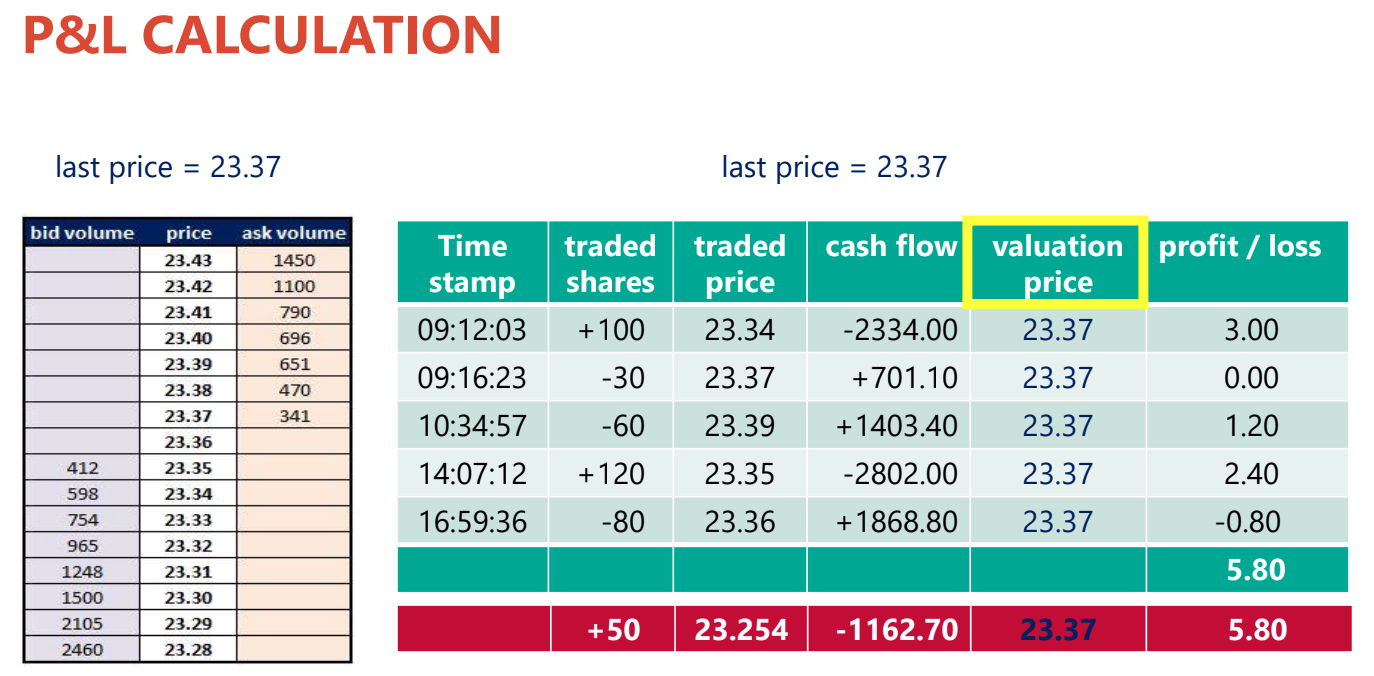
> 
>
> ##### `Key idea / steps of PnL calculation`
> 1. Get $\Longrightarrow$ cash flow = $-$price * size
> 2. Till current `timestamp`, get $\Longrightarrow$ avg traded price = $-$cumulative cash flow / cumulative position
> 3. Use current day's `close` price as `valuation price`
> 4. Till current `timestamp`, get $\Longrightarrow$  cumulative PnL = cumulative position * (close $-$ avg price)
 

##### Use an example of `instrument_id` to depict the steps

In [11]:
instrument_id = 34

# FX will be needed
currency = instruments_df.loc[instrument_id, 'currency']
fx_rate = fx_rates_df.loc[currency,'fx_rate']

##### Get `market_transactions` data for the `instrument_id `as it will be helpful to get `close` price of a day; Adjust `price` for `fx_rate`

In [12]:
market_trades_in_instrument_df = market_transactions_df.loc[instrument_id].copy()
market_trades_in_instrument_df['price'] /= fx_rate
market_trades_in_instrument_df

index    size  price
timestamp                                       
2021-01-02 09:06:29.326401      0  241656 391.28
2021-01-02 09:07:10.931728      1  241656 391.12
2021-01-02 09:14:02.415906      2  241656 390.34
2021-01-02 09:14:02.415906      3  241656 390.34
2021-01-02 09:18:09.036831      4  241656 390.16
...                           ...     ...    ...
2021-09-30 17:15:29.590728  50236  241656 473.28
2021-09-30 17:16:23.581489  50237  241656 473.35
2021-09-30 17:18:31.891824  50238  241656 473.27
2021-09-30 17:26:09.995805  50239  241656 473.93
2021-09-30 17:27:39.035587  50240  241656 473.72

[50241 rows x 3 columns]

##### Get `firm_transactions` data for the `instrument_id `; Adjust `price` for `fx_rate`

In [13]:
firm_trades_in_instrument_df = firm_transactions_df.loc[instrument_id].copy()
firm_trades_in_instrument_df['price'] /= fx_rate
firm_trades_in_instrument_df

index   size  price
timestamp                                      
2021-01-02 09:06:29.326401      0 -28.00 391.28
2021-01-02 09:07:10.931728      1  65.00 391.12
2021-01-02 09:14:02.415906      2 -68.00 390.34
2021-01-02 09:18:38.817740      3 -43.00 390.36
2021-01-02 09:19:22.251824      4  31.00 390.17
...                           ...    ...    ...
2021-09-30 17:05:18.330308  21957 -29.00 474.01
2021-09-30 17:08:45.020239  21958 -54.00 473.28
2021-09-30 17:15:29.590728  21959 -32.00 473.28
2021-09-30 17:16:23.581489  21960  92.00 473.35
2021-09-30 17:26:09.995805  21961 -50.00 473.93

[21962 rows x 3 columns]

##### Create `instrument_pnl_df` to carry out computations for `PnL` and initialize key columns

In [14]:
instrument_pnl_df = pd.DataFrame(index = firm_trades_in_instrument_df.index)

instrument_pnl_df['size'] = firm_trades_in_instrument_df['size'].astype(int)
instrument_pnl_df['price'] = firm_trades_in_instrument_df['price']

instrument_pnl_df

size  price
timestamp                              
2021-01-02 09:06:29.326401   -28 391.28
2021-01-02 09:07:10.931728    65 391.12
2021-01-02 09:14:02.415906   -68 390.34
2021-01-02 09:18:38.817740   -43 390.36
2021-01-02 09:19:22.251824    31 390.17
...                          ...    ...
2021-09-30 17:05:18.330308   -29 474.01
2021-09-30 17:08:45.020239   -54 473.28
2021-09-30 17:15:29.590728   -32 473.28
2021-09-30 17:16:23.581489    92 473.35
2021-09-30 17:26:09.995805   -50 473.93

[21962 rows x 2 columns]

##### Get `close` price
Get `close` price of the day at each `timestamp` in a vectorized / efficient way (resample `market_transactions` at daily frequency, get `last` row and reindex to `firm_transactions`'s index using forward fill `ffill`)

In [15]:
market_daily_close = market_trades_in_instrument_df.resample('D').last()['price'].dropna()
market_daily_close.to_frame()

price
timestamp        
2021-01-02 380.91
2021-01-04 379.33
2021-01-05 381.62
2021-01-06 380.14
2021-01-07 382.15
...           ...
2021-09-24 478.18
2021-09-27 486.14
2021-09-28 484.71
2021-09-29 480.66
2021-09-30 473.72

[195 rows x 1 columns]

In [16]:
instrument_pnl_df['close'] = market_daily_close.reindex(firm_trades_in_instrument_df.index, method = 'ffill')
instrument_pnl_df

size  price  close
timestamp                                     
2021-01-02 09:06:29.326401   -28 391.28 380.91
2021-01-02 09:07:10.931728    65 391.12 380.91
2021-01-02 09:14:02.415906   -68 390.34 380.91
2021-01-02 09:18:38.817740   -43 390.36 380.91
2021-01-02 09:19:22.251824    31 390.17 380.91
...                          ...    ...    ...
2021-09-30 17:05:18.330308   -29 474.01 473.72
2021-09-30 17:08:45.020239   -54 473.28 473.72
2021-09-30 17:15:29.590728   -32 473.28 473.72
2021-09-30 17:16:23.581489    92 473.35 473.72
2021-09-30 17:26:09.995805   -50 473.93 473.72

[21962 rows x 3 columns]

##### Get `cash flow`, `cumulative position` and `cumulative cash flow`

In [17]:
instrument_pnl_df['cash flow'] = -instrument_pnl_df['price'] * instrument_pnl_df['size']
instrument_pnl_df['cumulative position'] = instrument_pnl_df['size'].cumsum()
instrument_pnl_df['cumulative cash flow'] = instrument_pnl_df['cash flow'].cumsum()

instrument_pnl_df

size  price  close  cash flow  \
timestamp                                                   
2021-01-02 09:06:29.326401   -28 391.28 380.91   10955.77   
2021-01-02 09:07:10.931728    65 391.12 380.91  -25423.09   
2021-01-02 09:14:02.415906   -68 390.34 380.91   26543.19   
2021-01-02 09:18:38.817740   -43 390.36 380.91   16785.46   
2021-01-02 09:19:22.251824    31 390.17 380.91  -12095.31   
...                          ...    ...    ...        ...   
2021-09-30 17:05:18.330308   -29 474.01 473.72   13746.20   
2021-09-30 17:08:45.020239   -54 473.28 473.72   25557.28   
2021-09-30 17:15:29.590728   -32 473.28 473.72   15145.05   
2021-09-30 17:16:23.581489    92 473.35 473.72  -43548.31   
2021-09-30 17:26:09.995805   -50 473.93 473.72   23696.63   

                            cumulative position  cumulative cash flow  
timestamp                                                              
2021-01-02 09:06:29.326401                  -28              10955.77  
2021-01-02 09:07:10.931728                   37             -14467.32  
2021-01-02 09:14:02.415906                  -31              12075.88  
2021-01-02 09:18:38.817740                  -74              28861.34  
2021-01-02 09:19:22.251824                  -43              16766.03  
...                                         ...                   ...  
2021-09-30 17:05:18.330308                -4755            1791665.72  
2021-09-30 17:08:45.020239                -4809            1817223.00  
2021-09-30 17:15:29.590728                -4841            1832368.06  
2021-09-30 17:16:23.581489                -4749            1788819.74  
2021-09-30 17:26:09.995805                -4799            1812516.38  

[21962 rows x 6 columns]

##### Get `avg traded price` (yet) and `cumulative pnl`

In [18]:
instrument_pnl_df['avg traded price'] = -instrument_pnl_df['cumulative cash flow'] / instrument_pnl_df['cumulative position']
instrument_pnl_df['cumulative pnl'] = instrument_pnl_df['cumulative position'] * (instrument_pnl_df['close'] - \
                                                                                  instrument_pnl_df['avg traded price'])

instrument_pnl_df

size  price  close  cash flow  \
timestamp                                                   
2021-01-02 09:06:29.326401   -28 391.28 380.91   10955.77   
2021-01-02 09:07:10.931728    65 391.12 380.91  -25423.09   
2021-01-02 09:14:02.415906   -68 390.34 380.91   26543.19   
2021-01-02 09:18:38.817740   -43 390.36 380.91   16785.46   
2021-01-02 09:19:22.251824    31 390.17 380.91  -12095.31   
...                          ...    ...    ...        ...   
2021-09-30 17:05:18.330308   -29 474.01 473.72   13746.20   
2021-09-30 17:08:45.020239   -54 473.28 473.72   25557.28   
2021-09-30 17:15:29.590728   -32 473.28 473.72   15145.05   
2021-09-30 17:16:23.581489    92 473.35 473.72  -43548.31   
2021-09-30 17:26:09.995805   -50 473.93 473.72   23696.63   

                            cumulative position  cumulative cash flow  \
timestamp                                                               
2021-01-02 09:06:29.326401                  -28              10955.77   
2021-01-02 09:07:10.931728                   37             -14467.32   
2021-01-02 09:14:02.415906                  -31              12075.88   
2021-01-02 09:18:38.817740                  -74              28861.34   
2021-01-02 09:19:22.251824                  -43              16766.03   
...                                         ...                   ...   
2021-09-30 17:05:18.330308                -4755            1791665.72   
2021-09-30 17:08:45.020239                -4809            1817223.00   
2021-09-30 17:15:29.590728                -4841            1832368.06   
2021-09-30 17:16:23.581489                -4749            1788819.74   
2021-09-30 17:26:09.995805                -4799            1812516.38   

                            avg traded price  cumulative pnl  
timestamp                                                     
2021-01-02 09:06:29.326401            391.28          290.21  
2021-01-02 09:07:10.931728            391.01         -373.54  
2021-01-02 09:14:02.415906            389.54          267.57  
2021-01-02 09:18:38.817740            390.02          673.78  
2021-01-02 09:19:22.251824            389.91          386.77  
...                                      ...             ...  
2021-09-30 17:05:18.330308            376.80      -460858.96  
2021-09-30 17:08:45.020239            377.88      -460882.40  
2021-09-30 17:15:29.590728            378.51      -460896.29  
2021-09-30 17:16:23.581489            376.67      -460862.63  
2021-09-30 17:26:09.995805            377.69      -460851.85  

[21962 rows x 8 columns]

##### !!!!! Fix `edge case`: `cumulative position` $= 0$
> Our `cumulative pnl` columns may have `np.nan` because: 
> if `cumulative position` $= 0$ (i.e. net position is flat), then
> - We cannot compute `avg traded price` because denominator $= 0$
> $$\text{avg traded price} = - \frac{\text{cumulative cash flow}}{\text{cumulative position}}$$
> - We have to replace `cumulative pnl` with `cumulative cash flow` becuase what ever cash we are sitting with after trading out our positions is the realized PnL at that point. This fix also corrects our `pnl` calculation by avoiding double nans resulting from `.diff()` on a `nan`
>
> E.g. `instrument_id` = $34$
> 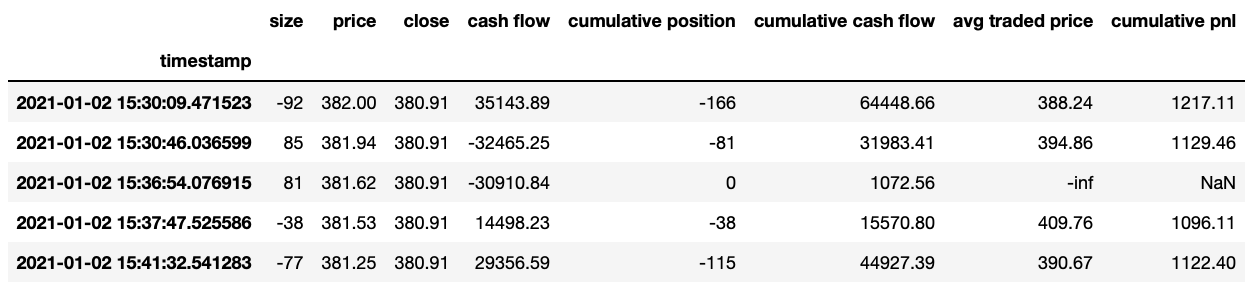

For now we will fix this with pandas `.fillna()` method but later (when we convert this process of getting pnl into a function to make code modular) we will use `numpy.select` to explicitly make this condition clear and code neater.

In [19]:
instrument_pnl_df['cumulative pnl'].fillna(instrument_pnl_df['cumulative cash flow'], inplace = True)

# the issue is fixed now (below is a visual for 'instrument_id' = 34)
instrument_pnl_df.iloc[102:107]

size  price  close  cash flow  \
timestamp                                                   
2021-01-02 15:30:09.471523   -92 382.00 380.91   35143.89   
2021-01-02 15:30:46.036599    85 381.94 380.91  -32465.25   
2021-01-02 15:36:54.076915    81 381.62 380.91  -30910.84   
2021-01-02 15:37:47.525586   -38 381.53 380.91   14498.23   
2021-01-02 15:41:32.541283   -77 381.25 380.91   29356.59   

                            cumulative position  cumulative cash flow  \
timestamp                                                               
2021-01-02 15:30:09.471523                 -166              64448.66   
2021-01-02 15:30:46.036599                  -81              31983.41   
2021-01-02 15:36:54.076915                    0               1072.56   
2021-01-02 15:37:47.525586                  -38              15570.80   
2021-01-02 15:41:32.541283                 -115              44927.39   

                            avg traded price  cumulative pnl  
timestamp                                                     
2021-01-02 15:30:09.471523            388.24         1217.11  
2021-01-02 15:30:46.036599            394.86         1129.46  
2021-01-02 15:36:54.076915              -inf         1072.56  
2021-01-02 15:37:47.525586            409.76         1096.11  
2021-01-02 15:41:32.541283            390.67         1122.40

##### Get `pnl` column

In [20]:
instrument_pnl_df['pnl'] = instrument_pnl_df['cumulative pnl'].diff()
instrument_pnl_df['pnl'].fillna(instrument_pnl_df['cumulative pnl'], inplace = True)        # fix first nan row from .diff()

instrument_pnl_df

size  price  close  cash flow  \
timestamp                                                   
2021-01-02 09:06:29.326401   -28 391.28 380.91   10955.77   
2021-01-02 09:07:10.931728    65 391.12 380.91  -25423.09   
2021-01-02 09:14:02.415906   -68 390.34 380.91   26543.19   
2021-01-02 09:18:38.817740   -43 390.36 380.91   16785.46   
2021-01-02 09:19:22.251824    31 390.17 380.91  -12095.31   
...                          ...    ...    ...        ...   
2021-09-30 17:05:18.330308   -29 474.01 473.72   13746.20   
2021-09-30 17:08:45.020239   -54 473.28 473.72   25557.28   
2021-09-30 17:15:29.590728   -32 473.28 473.72   15145.05   
2021-09-30 17:16:23.581489    92 473.35 473.72  -43548.31   
2021-09-30 17:26:09.995805   -50 473.93 473.72   23696.63   

                            cumulative position  cumulative cash flow  \
timestamp                                                               
2021-01-02 09:06:29.326401                  -28              10955.77   
2021-01-02 09:07:10.931728                   37             -14467.32   
2021-01-02 09:14:02.415906                  -31              12075.88   
2021-01-02 09:18:38.817740                  -74              28861.34   
2021-01-02 09:19:22.251824                  -43              16766.03   
...                                         ...                   ...   
2021-09-30 17:05:18.330308                -4755            1791665.72   
2021-09-30 17:08:45.020239                -4809            1817223.00   
2021-09-30 17:15:29.590728                -4841            1832368.06   
2021-09-30 17:16:23.581489                -4749            1788819.74   
2021-09-30 17:26:09.995805                -4799            1812516.38   

                            avg traded price  cumulative pnl     pnl  
timestamp                                                             
2021-01-02 09:06:29.326401            391.28          290.21  290.21  
2021-01-02 09:07:10.931728            391.01         -373.54 -663.75  
2021-01-02 09:14:02.415906            389.54          267.57  641.11  
2021-01-02 09:18:38.817740            390.02          673.78  406.21  
2021-01-02 09:19:22.251824            389.91          386.77 -287.01  
...                                      ...             ...     ...  
2021-09-30 17:05:18.330308            376.80      -460858.96    8.40  
2021-09-30 17:08:45.020239            377.88      -460882.40  -23.44  
2021-09-30 17:15:29.590728            378.51      -460896.29  -13.89  
2021-09-30 17:16:23.581489            376.67      -460862.63   33.66  
2021-09-30 17:26:09.995805            377.69      -460851.85   10.78  

[21962 rows x 9 columns]

##### Sanity check via `assert` to see if `cumulative position` $= 0$ edge case is fixed

In [21]:
assert round(instrument_pnl_df['cumulative pnl'][-1], 5) == round(instrument_pnl_df['pnl'].sum(), 5)

##### Create `instrument_daily_pnl_df` to store daily pnl performance

In [22]:
instrument_daily_pnl_df = instrument_pnl_df.resample('D').agg({'close': 'last',
                                                               'avg traded price': 'last',
                                                               'cumulative position': 'last',
                                                               'cumulative cash flow': 'last',
                                                               'cumulative pnl': 'last',
                                                               'pnl': 'sum'})

instrument_daily_pnl_df = instrument_daily_pnl_df.loc[market_daily_close.index]        # only take days when market is open
instrument_daily_pnl_df

close  avg traded price  cumulative position  \
timestamp                                                  
2021-01-02 380.91            372.95               155.00   
2021-01-04 379.33            370.99               187.00   
2021-01-05 381.62            379.22              1094.00   
2021-01-06 380.14            378.76               546.00   
2021-01-07 382.15            377.16               555.00   
...           ...               ...                  ...   
2021-09-24 478.18            346.70             -3721.00   
2021-09-27 486.14            355.64             -3986.00   
2021-09-28 484.71            383.17             -5081.00   
2021-09-29 480.66            379.25             -4881.00   
2021-09-30 473.72            377.69             -4799.00   

            cumulative cash flow  cumulative pnl       pnl  
timestamp                                                   
2021-01-02             -57807.24         1234.26   1234.26  
2021-01-04             -69374.30         1559.60    325.34  
2021-01-05            -414863.86         2625.49   1065.89  
2021-01-06            -206803.18          752.88  -1872.61  
2021-01-07            -209325.42         2769.99   2017.11  
...                          ...             ...       ...  
2021-09-24            1290063.43      -489238.59  -4939.06  
2021-09-27            1417582.13      -520161.26 -30922.67  
2021-09-28            1946909.15      -515917.43   4243.83  
2021-09-29            1851134.41      -494973.56  20943.87  
2021-09-30            1812516.38      -460851.85  34121.71  

[195 rows x 6 columns]

##### !!!!! Fix `edge case`: `Firm does not trade`
> It can be possible that market was open on a day but our firm did not trade on that day in a particular instrument. So we have to account for that (error creeps in due to daily resampling, which leaves nans for the day Firm does not trade)
>
> E.g. `instrument_id` = $275$
> 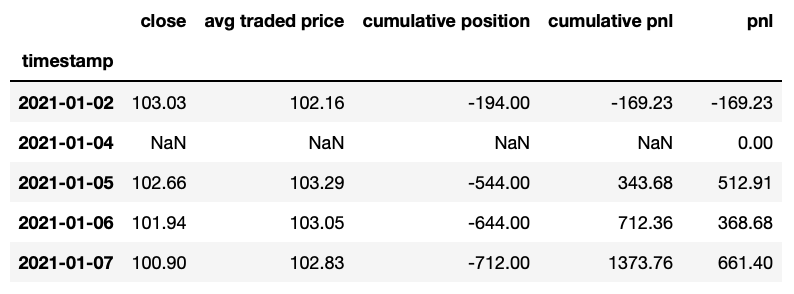
> In such cases
> - Get missing `close` prices from `market_daily_close` (missed due to daily resampling)
> - Forward fill `avg traded price` (since we don't trade, our average traded price doesn't change)
> - Forward fill `cumulative position` for similar reason above
> - Update `cumulative pnl` because `close` can change on the day we don't trade
> - Account for `cumulative position` $= 0$ edge case (can happen in daily resampling too)
> - Update `pnl` based on updated `cumulative pnl`

In [23]:
# Fill missing 'close', 'cumulative position' and 'avg traded price' (if any)
instrument_daily_pnl_df['close'].fillna(market_daily_close, inplace = True)
instrument_daily_pnl_df['cumulative position'].fillna(method = 'ffill', inplace = True)
instrument_daily_pnl_df['avg traded price'].fillna(method = 'ffill', inplace = True)

# Update 'cumulative pnl' (account for edge case 'cumulative position' = 0) and 'pnl' calculations
instrument_daily_pnl_df['cumulative pnl'] = instrument_daily_pnl_df['cumulative position'] * (instrument_daily_pnl_df['close'] - \
                                                                                              instrument_daily_pnl_df['avg traded price'])
instrument_daily_pnl_df['cumulative pnl'].fillna(instrument_daily_pnl_df['cumulative cash flow'], inplace = True)
instrument_daily_pnl_df['pnl'] = instrument_daily_pnl_df['cumulative pnl'].diff()
instrument_daily_pnl_df['pnl'].fillna(instrument_daily_pnl_df['cumulative pnl'], inplace = True)        # fix first nan row from .diff()

instrument_daily_pnl_df

close  avg traded price  cumulative position  \
timestamp                                                  
2021-01-02 380.91            372.95               155.00   
2021-01-04 379.33            370.99               187.00   
2021-01-05 381.62            379.22              1094.00   
2021-01-06 380.14            378.76               546.00   
2021-01-07 382.15            377.16               555.00   
...           ...               ...                  ...   
2021-09-24 478.18            346.70             -3721.00   
2021-09-27 486.14            355.64             -3986.00   
2021-09-28 484.71            383.17             -5081.00   
2021-09-29 480.66            379.25             -4881.00   
2021-09-30 473.72            377.69             -4799.00   

            cumulative cash flow  cumulative pnl       pnl  
timestamp                                                   
2021-01-02             -57807.24         1234.26   1234.26  
2021-01-04             -69374.30         1559.60    325.34  
2021-01-05            -414863.86         2625.49   1065.89  
2021-01-06            -206803.18          752.88  -1872.61  
2021-01-07            -209325.42         2769.99   2017.11  
...                          ...             ...       ...  
2021-09-24            1290063.43      -489238.59  -4939.06  
2021-09-27            1417582.13      -520161.26 -30922.67  
2021-09-28            1946909.15      -515917.43   4243.83  
2021-09-29            1851134.41      -494973.56  20943.87  
2021-09-30            1812516.38      -460851.85  34121.71  

[195 rows x 6 columns]

##### Sanity check via `assert` to see if `Firm does not trade` edge case is fixededge case is resolved

In [24]:
assert round(instrument_daily_pnl_df['pnl'].sum(), 5) == round(instrument_pnl_df['pnl'].sum(), 5)

##### Finally, let's write a function `get_pnl_data` to get all this PnL calculation under one hood

In [25]:
def get_pnl_data(instrument_id, 
                 instruments_df = instruments_df, 
                 fx_rates_df = fx_rates_df,
                 market_transactions_df = market_transactions_df, 
                 firm_transactions_df = firm_transactions_df):
    """
    This function carries out the process of PnL calculation for 'instrument_id'
    Note: Every price related metric (PnL, cash flow, etc.) are fx_rate adjusted
             
    Returns the following for 'instrument_id':
    -------
    1. instrument_daily_pnl_df : pandas DataFrame of daily PnL and other relevant metrics
    2. instrument_pnl_df       : pandas DataFrame of PnL and other metrics at each timestamp
    -------
    """
    # get currency and fx_rate
    currency = instruments_df.loc[instrument_id, 'currency']
    fx_rate = fx_rates_df.loc[currency,'fx_rate']
    
    
    # store DataFrame of market trades that happened in 'instrument_id'; Adjust price for FX
    market_trades_in_instrument_df = market_transactions_df.loc[instrument_id].copy()
    market_trades_in_instrument_df['price'] /= fx_rate
    
    
    # store DataFrame of trades that firm did in 'instrument_id'; Adjust price for FX
    firm_trades_in_instrument_df = firm_transactions_df.loc[instrument_id].copy()
    firm_trades_in_instrument_df['price'] /= fx_rate
    
    
    # initialize a DataFrame 'instrument_pnl_df' to carry out PnL related computations
    instrument_pnl_df = pd.DataFrame(index = firm_trades_in_instrument_df.index)
    
    
    # get size and price columns for 'instrument_pnl_df'
    instrument_pnl_df['size'] = firm_trades_in_instrument_df['size'].astype(int)
    instrument_pnl_df['price'] = firm_trades_in_instrument_df['price']
    
    
    # Get `close` price of the day at each `timestamp` in a vectorized / efficient way by
    # resampling market_trades at daily frequency, and get `last` (close) row of 'price'
    # column and reindex to `firm_transactions`'s index using forward fill ('ffill')
    market_daily_close = market_trades_in_instrument_df.resample('D').last()['price'].dropna()
    instrument_pnl_df['close'] = market_daily_close.reindex(firm_trades_in_instrument_df.index, method = 'ffill')
    
    
    # Get columns for 'cash flow', 'cumulative position', 'cumulative cash flow' and 'avg traded price'
    instrument_pnl_df['cash flow'] = -instrument_pnl_df['price'] * instrument_pnl_df['size']
    instrument_pnl_df['cumulative position'] = instrument_pnl_df['size'].cumsum()
    instrument_pnl_df['cumulative cash flow'] = instrument_pnl_df['cash flow'].cumsum()
    instrument_pnl_df['avg traded price'] = -instrument_pnl_df['cumulative cash flow'] / \
                                             instrument_pnl_df['cumulative position']
    
    
    # Get column for 'cumulative pnl' and deal with edge case of zero 'cumulative position' by .fillna()
    instrument_pnl_df['cumulative pnl'] = instrument_pnl_df['cumulative position'] * (instrument_pnl_df['close'] - \
                                                                                      instrument_pnl_df['avg traded price'])
    instrument_pnl_df['cumulative pnl'].fillna(instrument_pnl_df['cumulative cash flow'], inplace = True)
    
    
    # Get 'pnl' column; fix first nan row resulting from .diff() using .fillna()
    instrument_pnl_df['pnl'] = instrument_pnl_df['cumulative pnl'].diff()
    instrument_pnl_df['pnl'].fillna(instrument_pnl_df['cumulative pnl'], inplace = True)


    # Sanity check to see if 'cumulative position' edge case is fixed
    assert round(instrument_pnl_df['cumulative pnl'][-1], 5) == round(instrument_pnl_df['pnl'].sum(), 5)
    
    
    # Create 'instrument_daily_pnl_df' to store daily pnl performance
    instrument_daily_pnl_df = instrument_pnl_df.resample('D').agg({'close': 'last',
                                                                   'avg traded price': 'last',
                                                                   'cumulative position': 'last',
                                                                   'cumulative cash flow': 'last',
                                                                   'cumulative pnl': 'last',
                                                                   'pnl': 'sum'})

    instrument_daily_pnl_df = instrument_daily_pnl_df.loc[market_daily_close.index]        # only take days when market is open
    
    
    # Address for edge cases: fill missing 'close', 'cumulative position' and 'avg traded price' (if any)
    instrument_daily_pnl_df['close'].fillna(market_daily_close, inplace = True)
    instrument_daily_pnl_df['cumulative position'].fillna(method = 'ffill', inplace = True)
    instrument_daily_pnl_df['avg traded price'].fillna(method = 'ffill', inplace = True)

    
    # Update 'cumulative pnl' (account for edge case 'cumulative position' = 0) and 'pnl' calculations
    instrument_daily_pnl_df['cumulative pnl'] = instrument_daily_pnl_df['cumulative position'] * (instrument_daily_pnl_df['close'] - \
                                                                                                  instrument_daily_pnl_df['avg traded price'])
    instrument_daily_pnl_df['cumulative pnl'].fillna(instrument_daily_pnl_df['cumulative cash flow'], inplace = True)
    instrument_daily_pnl_df['pnl'] = instrument_daily_pnl_df['cumulative pnl'].diff()
    instrument_daily_pnl_df['pnl'].fillna(instrument_daily_pnl_df['cumulative pnl'], inplace = True)       # fix first nan row from .diff()
    
    
    # Sanity check to see if 'Firm does not trade' edge case is fixed
    assert round(instrument_daily_pnl_df['pnl'].sum(), 5) == round(instrument_pnl_df['pnl'].sum(), 5)

    
    return instrument_daily_pnl_df, instrument_pnl_df

##### Sanity check to see if our `get_pnl_data` function performs correctly

In [26]:
assert all(get_pnl_data(instrument_id)[0] == instrument_daily_pnl_df)

<a id='q1'></a>
# 5. `Question 1`
---
Please provide insight into the performance over the full period on a daily basis per stock and per trader in a format that you would present to the trader so that he can better understand where he needs to improve. 

<a id='s1'></a>
> ## `Solution / Code`
> Idea here is to get daily PnL data, extract some (sensible) summary statistics and make some (meaningful) plots to evaluate a Trader's performance and give them insights into their daily and YTD performance. 

##### Get `instrument_id`(s) in which Trader A and B trade

In [27]:
trader_A_stocks = [34, 54, 62, 72, 73, 84, 93, 146, 161]
trader_B_stocks = [214, 218, 231, 237, 239, 264, 266, 275, 292]

##### Use `dict` to store daily and full (all timestamp) pnl DataFrames for each stock in which Traders trade

In [28]:
trader_A_performance_dict = {stock: {} for stock in trader_A_stocks}
trader_B_performance_dict = {stock: {} for stock in trader_B_stocks}

In [29]:
for stock in trader_A_stocks:
    
    print(f"Calculating & storing PnL DataFrames for instrument id = {stock}")
    
    # get daily pnl and full pnl DataFrames 
    daily_pnl_df, full_pnl_df = get_pnl_data(stock)
    
    # store the DataFrames in performance dict
    trader_A_performance_dict[stock]['daily pnl df'] = daily_pnl_df
    trader_A_performance_dict[stock]['full pnl df'] = full_pnl_df

Calculating & storing PnL DataFrames for instrument id = 34
Calculating & storing PnL DataFrames for instrument id = 54
Calculating & storing PnL DataFrames for instrument id = 62
Calculating & storing PnL DataFrames for instrument id = 72
Calculating & storing PnL DataFrames for instrument id = 73
Calculating & storing PnL DataFrames for instrument id = 84
Calculating & storing PnL DataFrames for instrument id = 93
Calculating & storing PnL DataFrames for instrument id = 146
Calculating & storing PnL DataFrames for instrument id = 161


In [30]:
for stock in trader_B_stocks:
    
    print(f"Calculating & storing PnL DataFrames for instrument id = {stock}")
    
    # get daily pnl and full pnl DataFrames 
    daily_pnl_df, full_pnl_df = get_pnl_data(stock)
    
    # store the DataFrames in performance dict
    trader_B_performance_dict[stock]['daily pnl df'] = daily_pnl_df
    trader_B_performance_dict[stock]['full pnl df'] = full_pnl_df

Calculating & storing PnL DataFrames for instrument id = 214
Calculating & storing PnL DataFrames for instrument id = 218
Calculating & storing PnL DataFrames for instrument id = 231
Calculating & storing PnL DataFrames for instrument id = 237
Calculating & storing PnL DataFrames for instrument id = 239
Calculating & storing PnL DataFrames for instrument id = 264
Calculating & storing PnL DataFrames for instrument id = 266
Calculating & storing PnL DataFrames for instrument id = 275
Calculating & storing PnL DataFrames for instrument id = 292


##### Create `trader_X_daily_pnl_df` to store daily pnl for a trader's stocks in one DataFrame, it will be convenient for cross-sectional analysis

In [31]:
trader_A_daily_pnl_df = pd.DataFrame()
trader_B_daily_pnl_df = pd.DataFrame()

In [32]:
for stock in trader_A_stocks:
    trader_A_daily_pnl_df[stock] = trader_A_performance_dict[stock]['daily pnl df']['pnl']
    
trader_A_daily_pnl_df

34        54       62        72        73        84   \
timestamp                                                               
2021-01-02   1234.26   -234.69   364.89   -499.91   -435.44   -108.46   
2021-01-04    325.34  -2619.43   255.00  -3937.19   1803.67   2207.78   
2021-01-05   1065.89   9324.03  1154.49  -4151.70  -2254.49  -2066.63   
2021-01-06  -1872.61   5526.38   309.34   7884.01  -1613.67  -2886.02   
2021-01-07   2017.11   1156.96  1097.57    310.84  -5534.72   6151.21   
...              ...       ...      ...       ...       ...       ...   
2021-09-24  -4939.06  15895.31  1330.29 -11383.61   5454.07 -13452.93   
2021-09-27 -30922.67 -64429.18  -476.40   1973.12 -11162.45   9965.29   
2021-09-28   4243.83  26943.99 -2452.37  12519.68 -31121.57  -3118.75   
2021-09-29  20943.87  61062.64 -1884.97   1474.65   8239.38  -5312.01   
2021-09-30  34121.71 109262.91   958.04  -2777.34  -9789.32   4334.69   

                 93        146        161  
timestamp                                  
2021-01-02     33.69  -8957.31    1080.17  
2021-01-04    692.81  -1922.63     694.24  
2021-01-05  -1147.69   2299.84   14127.75  
2021-01-06  -2242.09   3322.48  -13549.01  
2021-01-07   2268.90  -7489.57   12776.68  
...              ...       ...        ...  
2021-09-24   2333.14  49599.06   16430.50  
2021-09-27  -9397.28  39213.77 -147628.37  
2021-09-28  16568.69  42891.45    7055.18  
2021-09-29 -10536.07 -13641.85   18837.08  
2021-09-30  11116.28 105126.09  -34149.92  

[195 rows x 9 columns]

In [33]:
for stock in trader_B_stocks:
    trader_B_daily_pnl_df[stock] = trader_B_performance_dict[stock]['daily pnl df']['pnl']
    
trader_B_daily_pnl_df

214       218      231       237       239       264  \
timestamp                                                             
2021-01-02    3.08  -1563.39   319.78   -490.06   1991.93   -935.15   
2021-01-04  -85.98    405.49 -1046.85    667.88  -1914.28   4190.46   
2021-01-05  -31.70   2205.17   444.51   2450.41   5707.35   -310.31   
2021-01-06  -28.30   2468.23    67.68   1293.88 -17089.45    168.52   
2021-01-07  -68.18   2930.03  -174.08   1095.88  11969.34   -642.46   
...            ...       ...      ...       ...       ...       ...   
2021-09-24 -139.52 -14095.24 -2168.48   3884.46   7491.24 -10895.23   
2021-09-27  862.32 -12518.21 -9092.51 -21798.82    384.41  -9485.90   
2021-09-28   32.44   1487.97 -9817.08 -24554.23    120.09  -7803.61   
2021-09-29  244.42   7701.99 12127.49 -12956.96   3525.44   1858.59   
2021-09-30  650.02  -7868.42   315.81  11710.96  -2050.19    198.54   

                  266       275      292  
timestamp                                 
2021-01-02   -1125.41   -169.23    33.43  
2021-01-04   -5071.90   -211.46   -15.27  
2021-01-05   12821.55    724.37    43.07  
2021-01-06    -604.58    368.68     4.61  
2021-01-07  -11614.92    661.40  -178.58  
...               ...       ...      ...  
2021-09-24  -15829.48 -18130.59  -480.64  
2021-09-27 -265989.98  29650.55 -1714.18  
2021-09-28   59606.99   -441.16  -437.32  
2021-09-29   47820.41  14258.78 -1914.33  
2021-09-30  -87274.79  -1537.73 -2302.83  

[195 rows x 9 columns]

##### Get `Portfolio` PnL as well, which is sum of PnL of all (trader's) stocks on each day

In [34]:
trader_A_daily_pnl_df['Portfolio'] = trader_A_daily_pnl_df.sum(axis = 'columns')
trader_A_daily_pnl_df

34        54       62        72        73        84  \
timestamp                                                               
2021-01-02   1234.26   -234.69   364.89   -499.91   -435.44   -108.46   
2021-01-04    325.34  -2619.43   255.00  -3937.19   1803.67   2207.78   
2021-01-05   1065.89   9324.03  1154.49  -4151.70  -2254.49  -2066.63   
2021-01-06  -1872.61   5526.38   309.34   7884.01  -1613.67  -2886.02   
2021-01-07   2017.11   1156.96  1097.57    310.84  -5534.72   6151.21   
...              ...       ...      ...       ...       ...       ...   
2021-09-24  -4939.06  15895.31  1330.29 -11383.61   5454.07 -13452.93   
2021-09-27 -30922.67 -64429.18  -476.40   1973.12 -11162.45   9965.29   
2021-09-28   4243.83  26943.99 -2452.37  12519.68 -31121.57  -3118.75   
2021-09-29  20943.87  61062.64 -1884.97   1474.65   8239.38  -5312.01   
2021-09-30  34121.71 109262.91   958.04  -2777.34  -9789.32   4334.69   

                  93       146        161  Portfolio  
timestamp                                             
2021-01-02     33.69  -8957.31    1080.17   -7522.81  
2021-01-04    692.81  -1922.63     694.24   -2500.42  
2021-01-05  -1147.69   2299.84   14127.75   18351.49  
2021-01-06  -2242.09   3322.48  -13549.01   -5121.17  
2021-01-07   2268.90  -7489.57   12776.68   12754.99  
...              ...       ...        ...        ...  
2021-09-24   2333.14  49599.06   16430.50   61266.78  
2021-09-27  -9397.28  39213.77 -147628.37 -212864.17  
2021-09-28  16568.69  42891.45    7055.18   73530.13  
2021-09-29 -10536.07 -13641.85   18837.08   79182.73  
2021-09-30  11116.28 105126.09  -34149.92  218203.13  

[195 rows x 10 columns]

In [35]:
trader_B_daily_pnl_df['Portfolio'] = trader_B_daily_pnl_df.sum(axis = 'columns')
trader_B_daily_pnl_df

214       218      231       237       239       264  \
timestamp                                                             
2021-01-02    3.08  -1563.39   319.78   -490.06   1991.93   -935.15   
2021-01-04  -85.98    405.49 -1046.85    667.88  -1914.28   4190.46   
2021-01-05  -31.70   2205.17   444.51   2450.41   5707.35   -310.31   
2021-01-06  -28.30   2468.23    67.68   1293.88 -17089.45    168.52   
2021-01-07  -68.18   2930.03  -174.08   1095.88  11969.34   -642.46   
...            ...       ...      ...       ...       ...       ...   
2021-09-24 -139.52 -14095.24 -2168.48   3884.46   7491.24 -10895.23   
2021-09-27  862.32 -12518.21 -9092.51 -21798.82    384.41  -9485.90   
2021-09-28   32.44   1487.97 -9817.08 -24554.23    120.09  -7803.61   
2021-09-29  244.42   7701.99 12127.49 -12956.96   3525.44   1858.59   
2021-09-30  650.02  -7868.42   315.81  11710.96  -2050.19    198.54   

                  266       275      292  Portfolio  
timestamp                                            
2021-01-02   -1125.41   -169.23    33.43   -1935.02  
2021-01-04   -5071.90   -211.46   -15.27   -3081.92  
2021-01-05   12821.55    724.37    43.07   24054.42  
2021-01-06    -604.58    368.68     4.61  -13350.72  
2021-01-07  -11614.92    661.40  -178.58    3978.42  
...               ...       ...      ...        ...  
2021-09-24  -15829.48 -18130.59  -480.64  -50363.48  
2021-09-27 -265989.98  29650.55 -1714.18 -289702.33  
2021-09-28   59606.99   -441.16  -437.32   18194.08  
2021-09-29   47820.41  14258.78 -1914.33   72665.83  
2021-09-30  -87274.79  -1537.73 -2302.83  -88158.63  

[195 rows x 10 columns]

##### Cumulative PnL evolution plot - Trader A

In [36]:
# useful to custom format PnL axis
import matplotlib.ticker as tick

def pnl_axis_formatter(tick_val, pos):
    """Custom formatter for pnl axis, useful in case of large PnL numbers"""
    if abs(tick_val) >= 10**6:
        val = round(tick_val, 2) / 10**6
        return f'{val:.2f} M'                # make unit in Millions
    
    elif abs(tick_val) > 1000:
        val = int(tick_val) / 1000
        return f'{val:.0f} K'                # make unit in Ks (1000s)
    
    else:
        return f'{tick_val:.0f}'

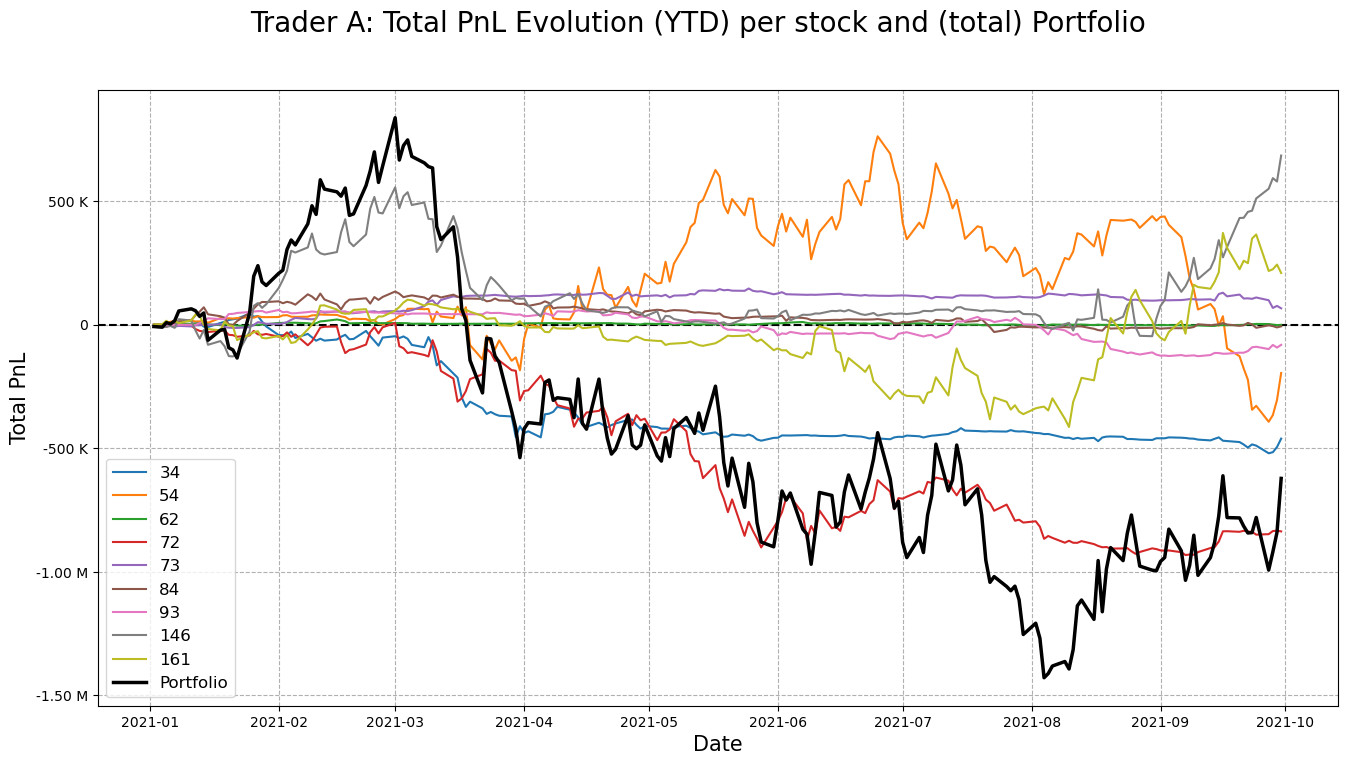

In [37]:
trader_A_cumulative_pnl_plot, ax1 = plt.subplots(1, figsize = (16, 8))

trader_A_cumulative_pnl_plot.suptitle('Trader A: Total PnL Evolution (YTD) per stock and (total) Portfolio', size = 20)
ax1.set_xlabel('Date', size = 15)
ax1.set_ylabel('Total PnL', size = 15)
ax1.grid(True, linestyle = '--')

# zero line
ax1.axhline(0, color = 'k', linestyle = '--')

# PnL axis format
ax1.yaxis.set_major_formatter(tick.FuncFormatter(pnl_axis_formatter))

# plot cumulative PnL for each stock
for stock in trader_A_stocks:
    ax1.plot(trader_A_daily_pnl_df[stock].cumsum(), label = f'{stock}')

# Portfolio PnL plot   
ax1.plot(trader_A_daily_pnl_df['Portfolio'].cumsum(), linewidth = 2.5, color = 'k', label = f'Portfolio')

ax1.legend(fontsize = 12);

##### Cumulative PnL evolution plot - Trader B

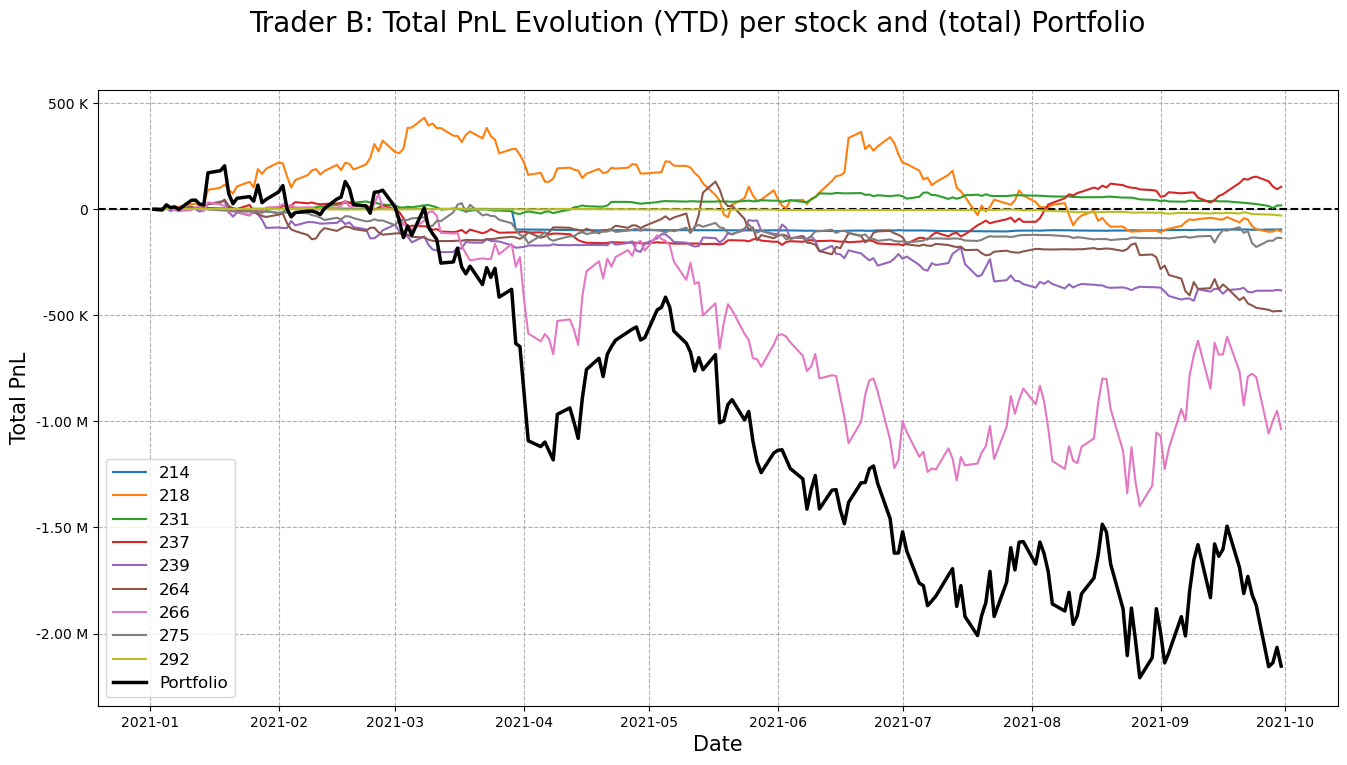

In [38]:
trader_B_cumulative_pnl_plot, ax2 = plt.subplots(1, figsize = (16, 8))

trader_B_cumulative_pnl_plot.suptitle('Trader B: Total PnL Evolution (YTD) per stock and (total) Portfolio', size = 20)
ax2.set_xlabel('Date', size = 15)
ax2.set_ylabel('Total PnL', size = 15)
ax2.grid(True, linestyle = '--')

# zero line
ax2.axhline(0, color = 'k', linestyle = '--')

# PnL axis format
ax2.yaxis.set_major_formatter(tick.FuncFormatter(pnl_axis_formatter))

# plot cumulative PnL for each stock
for stock in trader_B_stocks:
    ax2.plot(trader_B_daily_pnl_df[stock].cumsum(), label = f'{stock}')

# Portfolio PnL plot   
ax2.plot(trader_B_daily_pnl_df['Portfolio'].cumsum(), linewidth = 2.5, color = 'k', label = f'Portfolio')

ax2.legend(fontsize = 12);

##### Cumulative Position Value evolution plot - Trader A

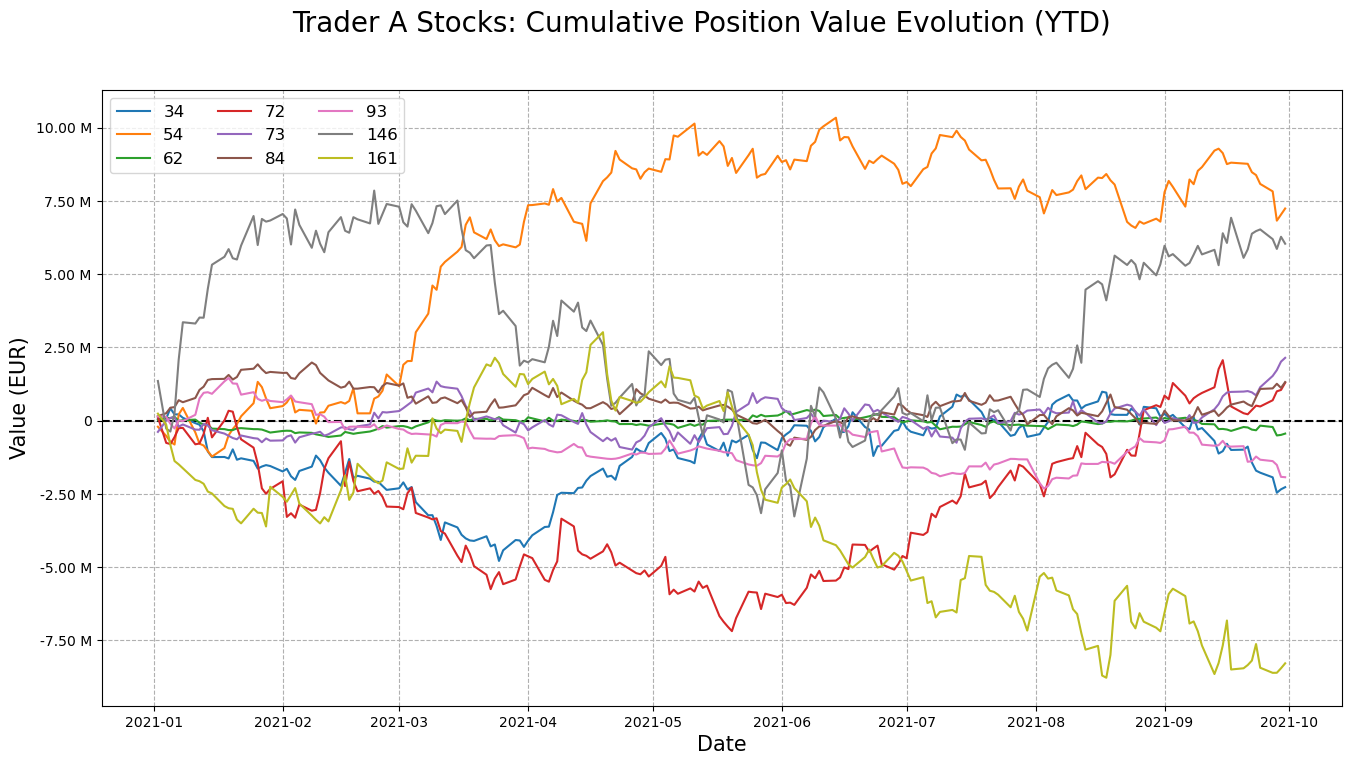

In [39]:
trader_A_cumulative_position_value_plot, ax7 = plt.subplots(1, figsize = (16, 8))

trader_A_cumulative_position_value_plot.suptitle('Trader A Stocks: Cumulative Position Value Evolution (YTD)', size = 20)
ax7.set_xlabel('Date', size = 15)
ax7.set_ylabel('Value (EUR)', size = 15)
ax7.grid(True, linestyle = '--')

# zero line
ax7.axhline(0, color = 'k', linestyle = '--')

# PnL axis format
ax7.yaxis.set_major_formatter(tick.FuncFormatter(pnl_axis_formatter))

# plot cumulative position for each stock
for stock in trader_A_stocks:
    plt.plot(trader_A_performance_dict[stock]['daily pnl df']['close']* \
             trader_A_performance_dict[stock]['daily pnl df']['cumulative position'], label = stock)

ax7.legend(fontsize = 12, ncol = 3);

##### Cumulative Position Value evolution plot - Trader B

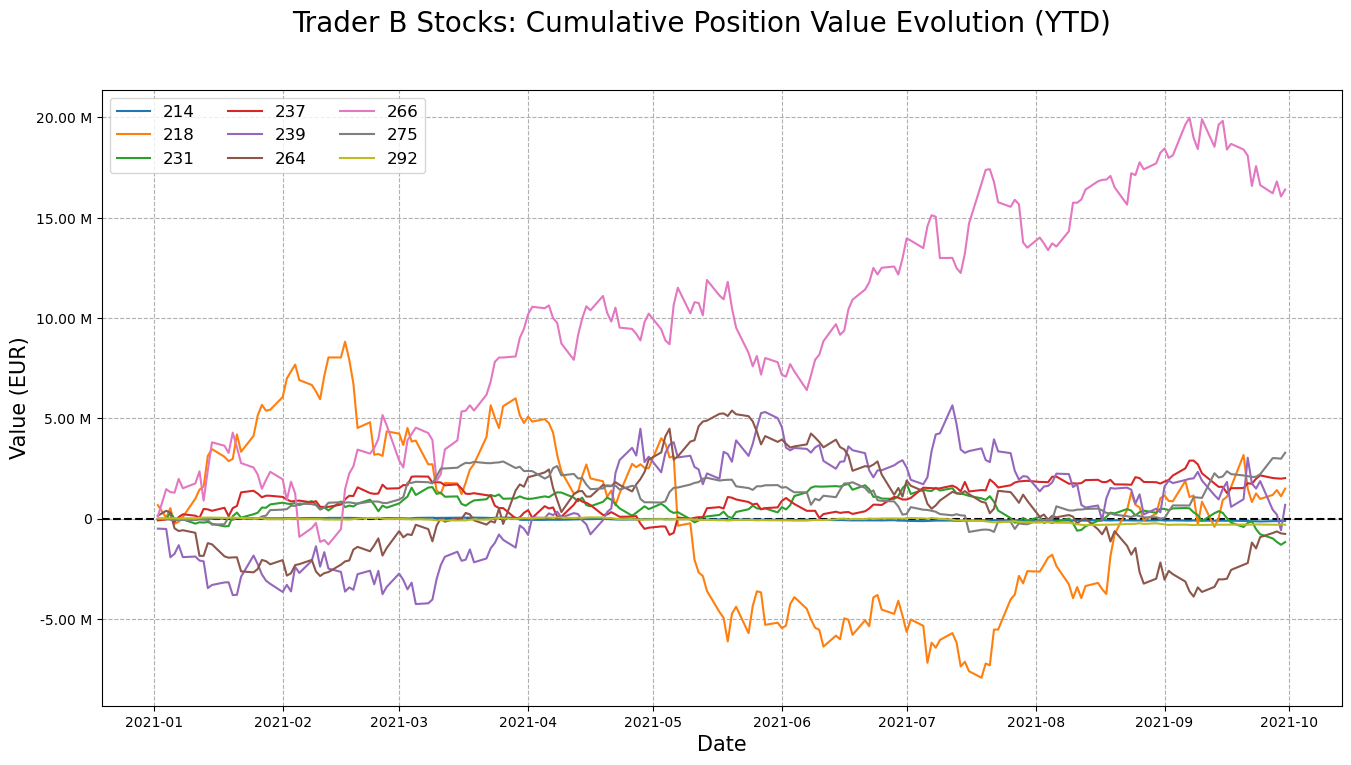

In [40]:
trader_B_cumulative_position_value_plot, ax8 = plt.subplots(1, figsize = (16, 8))

trader_B_cumulative_position_value_plot.suptitle('Trader B Stocks: Cumulative Position Value Evolution (YTD)', size = 20)
ax8.set_xlabel('Date', size = 15)
ax8.set_ylabel('Value (EUR)', size = 15)
ax8.grid(True, linestyle = '--')

# zero line
ax8.axhline(0, color = 'k', linestyle = '--')

# PnL axis format
ax8.yaxis.set_major_formatter(tick.FuncFormatter(pnl_axis_formatter))

# plot cumulative position for each stock
for stock in trader_B_stocks:
    plt.plot(trader_B_performance_dict[stock]['daily pnl df']['close']* \
             trader_B_performance_dict[stock]['daily pnl df']['cumulative position'], label = stock)

ax8.legend(fontsize = 12, ncol = 3);

##### Total PnL per stock plot - Trader A

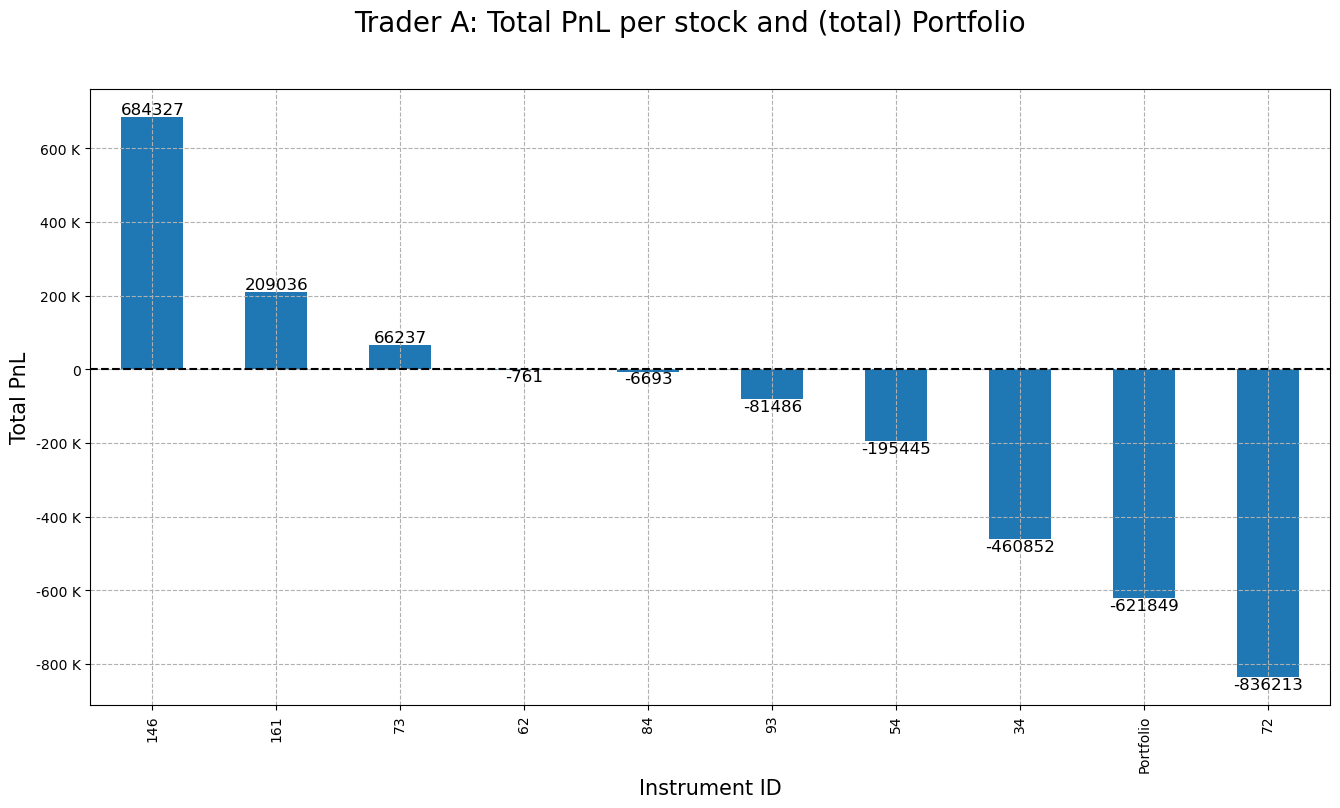

In [41]:
trader_A_total_pnl_per_stock_plot, ax3 = plt.subplots(1, figsize = (16, 8))

plot = trader_A_daily_pnl_df.sum().sort_values(ascending = False).plot.bar()
plot.bar_label(plot.containers[0], fmt = '%.0f', size = 12)

trader_A_total_pnl_per_stock_plot.suptitle('Trader A: Total PnL per stock and (total) Portfolio', size = 20)
ax3.set_xlabel('Instrument ID', size = 15)
ax3.set_ylabel('Total PnL', size = 15)
ax3.axhline(0, color = 'k', linestyle = '--',)
ax3.grid(True, linestyle = '--')
ax3.yaxis.set_major_formatter(tick.FuncFormatter(pnl_axis_formatter));

##### Total PnL per stock plot - Trader B

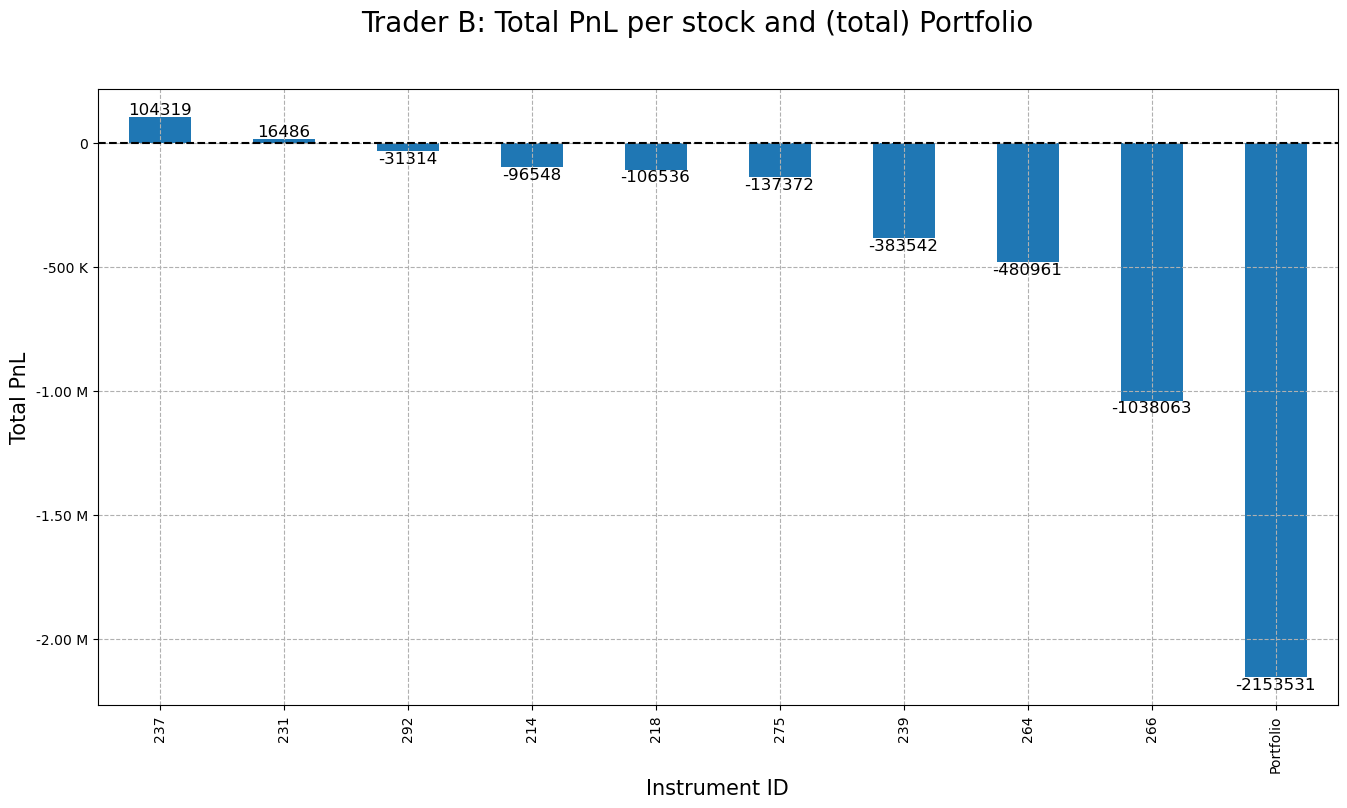

In [42]:
trader_B_total_pnl_per_stock_plot, ax4 = plt.subplots(1, figsize = (16, 8))

plot = trader_B_daily_pnl_df.sum().sort_values(ascending = False).plot.bar()
plot.bar_label(plot.containers[0], fmt = '%.0f', size = 12)

trader_B_total_pnl_per_stock_plot.suptitle('Trader B: Total PnL per stock and (total) Portfolio', size = 20)
ax4.set_xlabel('Instrument ID', size = 15)
ax4.set_ylabel('Total PnL', size = 15)
ax4.axhline(0, color = 'k', linestyle = '--',)
ax4.grid(True, linestyle = '--')
ax4.yaxis.set_major_formatter(tick.FuncFormatter(pnl_axis_formatter));

##### Define some performance metrics and store them in `trader_X_performance_metrics_df` DataFrame
- Note the `np.sqrt(252)` factor to annualize metrics like `sharpe` and `volatility` to get their annualized versions
- $252$: number of trading days in a year

In [43]:
annual_trading_days = 252

##### Function to get `maximum drawdown` of a series

In [44]:
def maximum_drawdown(series):
    """Helper function to calculate maximum drawdown of a pandas series"""
    cumulative = series.cumsum()
    roll_min_idx = np.argmax(np.maximum.accumulate(cumulative) - cumulative)
    roll_max_idx = np.argmax(cumulative[:roll_min_idx])

    return cumulative[roll_max_idx] - cumulative[roll_min_idx]

##### Get performance metrics for Trader A in `trader_A_performance_df`

In [45]:
metrics = ['total pnl', 'total pnl rank', 'sharpe', 'sharpe rank', 'volatility', 'volatility rank',
           'max drawdown', 'max drawdown rank', '% win days', '% win days rank']

trader_A_performance_df = pd.DataFrame(columns = trader_A_daily_pnl_df.columns,
                                       index = metrics)

trader_A_performance_df.loc['sharpe'] = np.sqrt(annual_trading_days) * trader_A_daily_pnl_df.mean() / trader_A_daily_pnl_df.std()
trader_A_performance_df.loc['sharpe rank'] = trader_A_performance_df.loc['sharpe'].rank(ascending = False).astype(int)

trader_A_performance_df.loc['volatility'] = np.sqrt(annual_trading_days) * trader_A_daily_pnl_df.std()
trader_A_performance_df.loc['volatility rank'] = trader_A_performance_df.loc['volatility'].rank().astype(int)

trader_A_performance_df.loc['total pnl'] = trader_A_daily_pnl_df.sum()
trader_A_performance_df.loc['total pnl rank'] = trader_A_performance_df.loc['total pnl'].rank(ascending = False).astype(int)

trader_A_performance_df.loc['% win days'] = (trader_A_daily_pnl_df > 0).mean()
trader_A_performance_df.loc['% win days rank'] = trader_A_performance_df.loc['% win days'].rank(ascending = False).astype(int)


trader_A_performance_df.loc['max drawdown'] = trader_A_daily_pnl_df.apply(maximum_drawdown)
trader_A_performance_df.loc['max drawdown rank'] = trader_A_performance_df.loc['max drawdown'].rank().astype(int)

trader_A_performance_df = trader_A_performance_df.T    # transpose for better viewing
trader_A_performance_df.sort_values(['total pnl'], ascending = False, inplace = True)

trader_A_performance_df

total pnl total pnl rank sharpe sharpe rank volatility  \
146        684326.89              1   1.33           1  663821.26   
161        209035.97              2   0.44           3  620828.90   
73          66237.14              3   0.80           2  107047.17   
62           -760.81              4  -0.04           4   24846.13   
84          -6693.21              5  -0.06           5  156797.68   
93         -81485.53              6  -0.83           8  127492.14   
54        -195444.87              7  -0.27           6  936980.30   
34        -460851.85              8  -2.14          10  278184.71   
Portfolio -621849.14              9  -0.49           7 1647558.21   
72        -836212.86             10  -1.82           9  593597.19   

          volatility rank max drawdown max drawdown rank % win days  \
146                     8    602043.28                 7       0.53   
161                     7    514940.16                 5       0.49   
73                      2     80161.85                 2       0.51   
62                      1     26065.01                 1       0.51   
84                      4    163842.84                 3       0.48   
93                      3    186960.26                 4       0.49   
54                      9   1154860.32                 9       0.49   
34                      5    564749.58                 6       0.45   
Portfolio              10   2265520.92                10       0.48   
72                      6    938793.28                 8       0.47   

          % win days rank  
146                     1  
161                     4  
73                      2  
62                      3  
84                      8  
93                      5  
54                      5  
34                     10  
Portfolio               7  
72                      9

##### Get performance metrics for Trader B in `trader_B_performance_df`

In [46]:
trader_B_performance_df = pd.DataFrame(columns = trader_B_daily_pnl_df.columns,
                                       index = metrics)

trader_B_performance_df.loc['sharpe'] = np.sqrt(annual_trading_days) * trader_B_daily_pnl_df.mean() / trader_B_daily_pnl_df.std()
trader_B_performance_df.loc['sharpe rank'] = trader_B_performance_df.loc['sharpe'].rank(ascending = False).astype(int)

trader_B_performance_df.loc['volatility'] = np.sqrt(annual_trading_days) * trader_B_daily_pnl_df.std()
trader_B_performance_df.loc['volatility rank'] = trader_B_performance_df.loc['volatility'].rank().astype(int)

trader_B_performance_df.loc['total pnl'] = trader_B_daily_pnl_df.sum()
trader_B_performance_df.loc['total pnl rank'] = trader_B_performance_df.loc['total pnl'].rank(ascending = False).astype(int)

trader_B_performance_df.loc['% win days'] = (trader_B_daily_pnl_df > 0).mean()
trader_B_performance_df.loc['% win days rank'] = trader_B_performance_df.loc['% win days'].rank(ascending = False).astype(int)


trader_B_performance_df.loc['max drawdown'] = trader_B_daily_pnl_df.apply(maximum_drawdown)
trader_B_performance_df.loc['max drawdown rank'] = trader_B_performance_df.loc['max drawdown'].rank().astype(int)

trader_B_performance_df = trader_B_performance_df.T    # transpose for better viewing
trader_B_performance_df.sort_values(['total pnl'], ascending = False, inplace = True)

trader_B_performance_df

total pnl total pnl rank sharpe sharpe rank volatility  \
237         104318.80              1   0.73           1  185505.55   
231          16485.84              2   0.25           2   84076.32   
292         -31313.93              3  -2.34          10   17329.77   
214         -96547.98              4  -1.14           6  109527.23   
218        -106536.48              5  -0.27           3  519333.62   
275        -137371.66              6  -0.80           4  223254.65   
239        -383541.80              7  -1.44           7  344965.60   
264        -480961.28              8  -1.79           9  347868.34   
266       -1038062.87              9  -0.94           5 1422736.28   
Portfolio -2153531.36             10  -1.70           8 1634034.66   

          volatility rank max drawdown max drawdown rank % win days  \
237                     4    207114.68                 5       0.50   
231                     2     73033.35                 2       0.45   
292                     1     32630.06                 1       0.41   
214                     3    108092.27                 3       0.48   
218                     8    539669.45                 7       0.52   
275                     5    206675.88                 4       0.49   
239                     6    470027.37                 6       0.44   
264                     7    611659.42                 8       0.47   
266                     9   1470658.06                 9       0.48   
Portfolio              10   2411022.18                10       0.51   

          % win days rank  
237                     3  
231                     8  
292                    10  
214                     5  
218                     1  
275                     4  
239                     9  
264                     7  
266                     5  
Portfolio               2

##### Annualized Sharpe Ratio per stock plot - Trader A

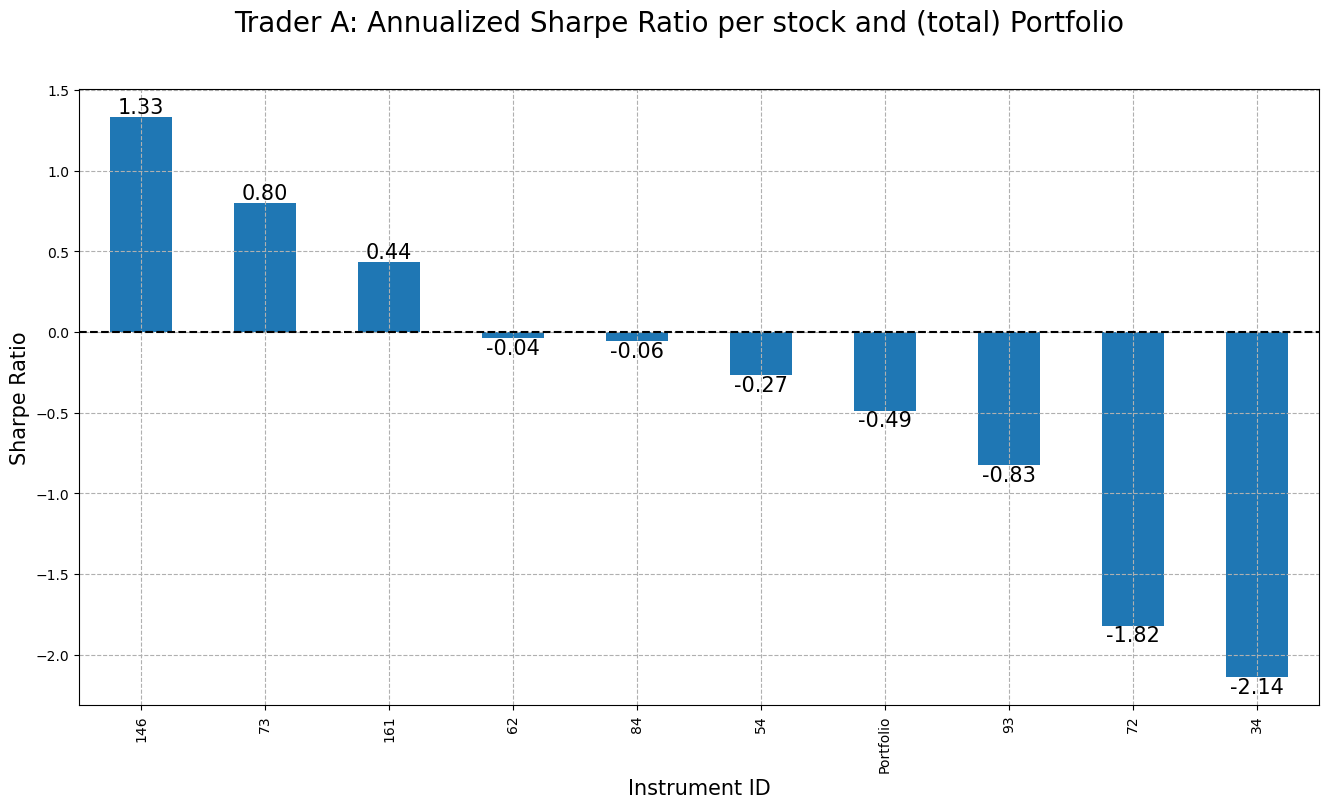

In [47]:
trader_A_sharpe_per_stock_plot, ax5 = plt.subplots(1, figsize = (16, 8))

plot = trader_A_performance_df.loc[:, 'sharpe'].sort_values(ascending = False).plot.bar()
plot.bar_label(plot.containers[0], fmt = '%.2f', size = 15)

trader_A_sharpe_per_stock_plot.suptitle('Trader A: Annualized Sharpe Ratio per stock and (total) Portfolio', size = 20)
ax5.set_xlabel('Instrument ID', size = 15)
ax5.set_ylabel('Sharpe Ratio', size = 15)
ax5.axhline(0, color = 'k', linestyle = '--',)
ax5.grid(True, linestyle = '--');

##### Annualized Sharpe Ratio per stock plot - Trader B

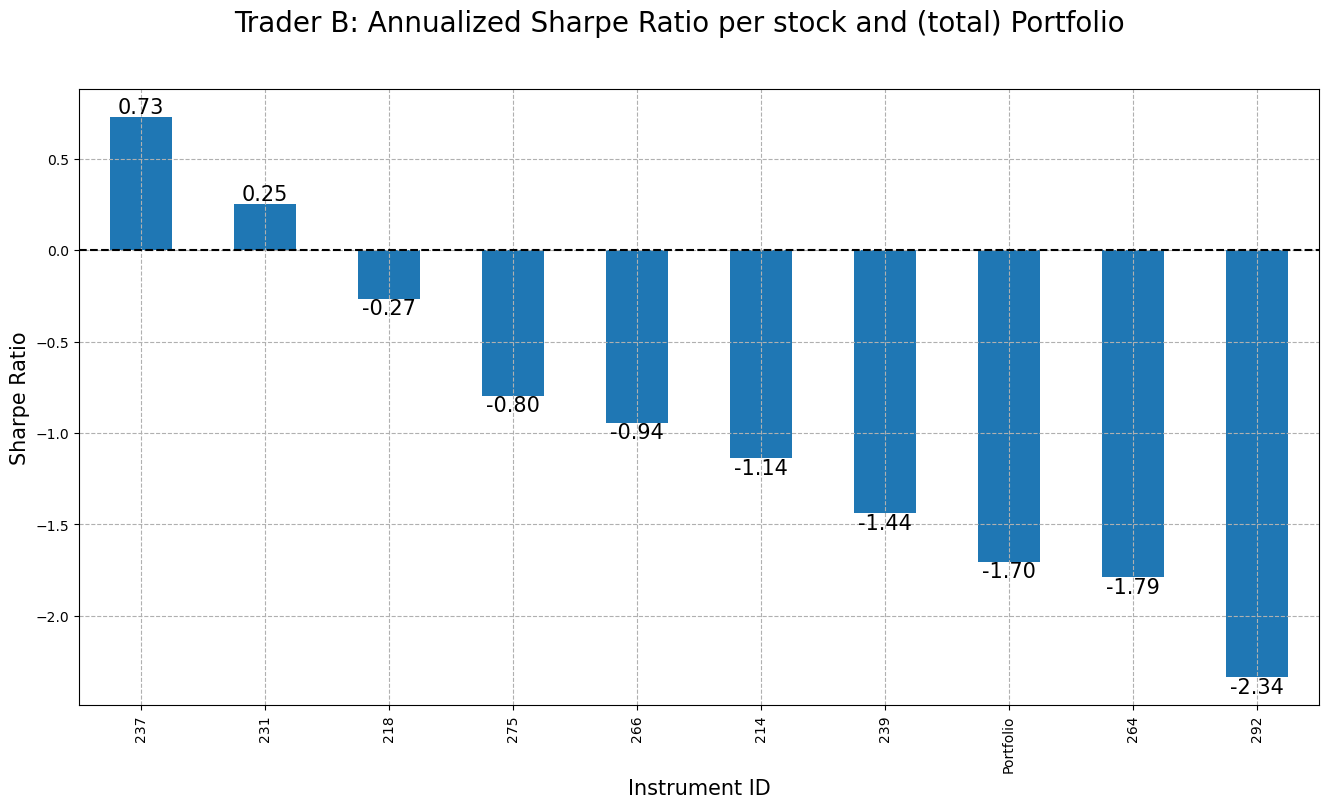

In [48]:
trader_B_sharpe_per_stock_plot, ax6 = plt.subplots(1, figsize = (16, 8))

plot = trader_B_performance_df.loc[:, 'sharpe'].sort_values(ascending = False).plot.bar()
plot.bar_label(plot.containers[0], fmt = '%.2f', size = 15)

trader_B_sharpe_per_stock_plot.suptitle('Trader B: Annualized Sharpe Ratio per stock and (total) Portfolio', size = 20)
ax6.set_xlabel('Instrument ID', size = 15)
ax6.set_ylabel('Sharpe Ratio', size = 15)
ax6.axhline(0, color = 'k', linestyle = '--',)
ax6.grid(True, linestyle = '--');

<a id='a1'></a>
## `Answer 1`
>
> ##### For  both the Traders, I show them the following:
>> - **`Total PnL Evolution plot`**: Give a summary of how the portfolio has performed over time during the trading period. Look for winners, losers, volatility, any patterns / trends or sudden / strange events etc.
>> - **`Total Position Evolution plot`**: Give a summary of how the positions varied and how much `long / short` were we in portfolio over time during the trading period. Look for variation in positions, extreme positions (if any), any pattern or strange / sudden events etc.
>> - **`Total PnL Bar plot`**: Give a summary where the portfolio stands as of today i.e. `year-to-date (YTD)` in terms of PnL (final performance). Focus on winners, losers and the magnitudes of their wins and loses
>> - **`Annualized Sharpe Ratio Bar plot`**: Give a summary of the portfolio's YTD `risk` adjusted performance. Focus on winners, losers and their magnitudes - to get an idea of how consistently money was made or lost
>
> ##### Can also be shown:
>> - Histogram / distribution of (total) Portfolio's daily PnL per trader to get an idea if daily PnL distribution is concentrated or `fat-tailed`, follows any known distribution (e.g. normal) etc. 
>> - Bar plot of average daily PnL per stock per trader (the information is partially captured in Total PnL bar plot)
>> - Bar plot of volatility per stock per trader (this information is partially captured in Sharpe ratio bar plot)
>> - Daily PnL evolution per stock per trader (plot will be multiple zig zag lines, so maybe not much insightful; also this information is partially captured in cumulative PnL plot)
>> - Can use rolling / moving window estimates (if needed)

### `Trader A`
##### `Trader A:  Total PnL Evolution plot` - focus on winners, losers, volatility, any patterns / trends / strange occurings

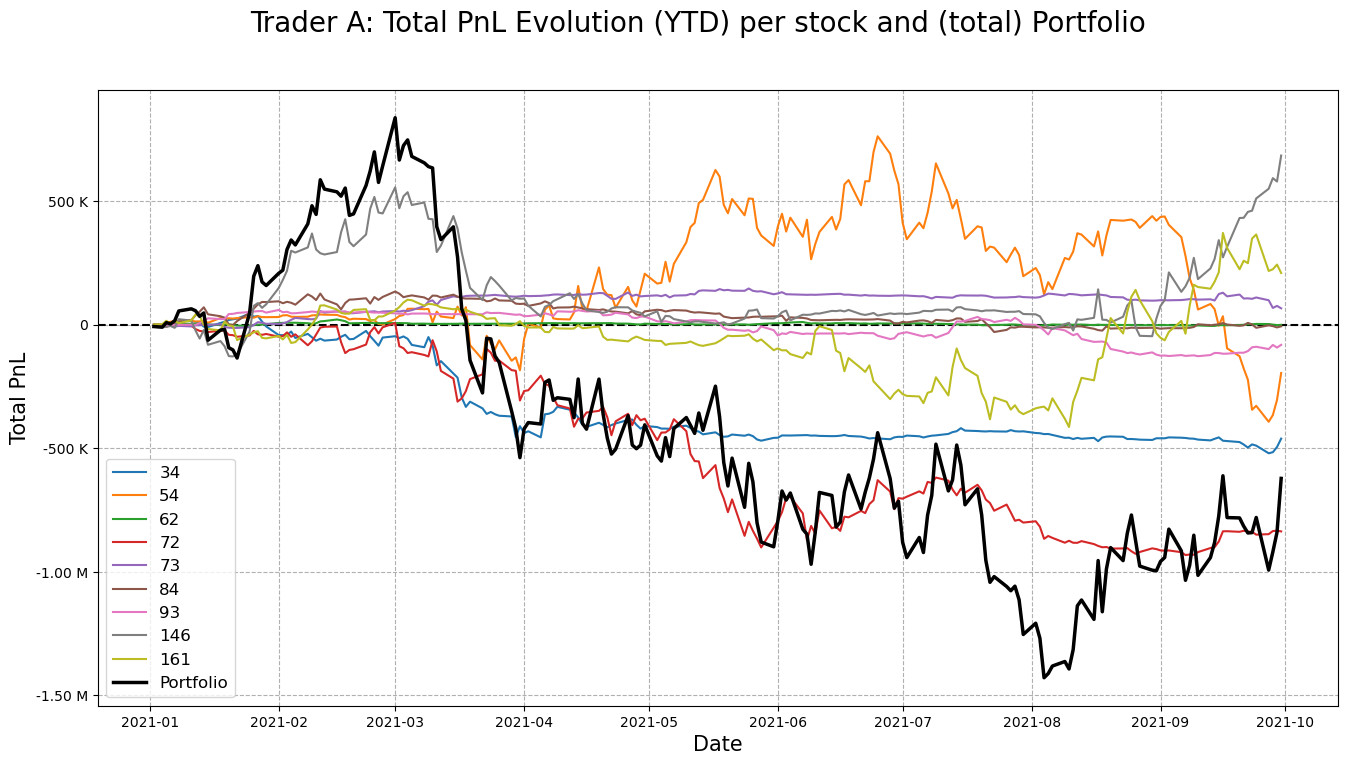

In [49]:
trader_A_cumulative_pnl_plot

##### `Trader A: Total Position Value Evolution plot` - variation in position, extreme positions, any pattern or strange / sudden event

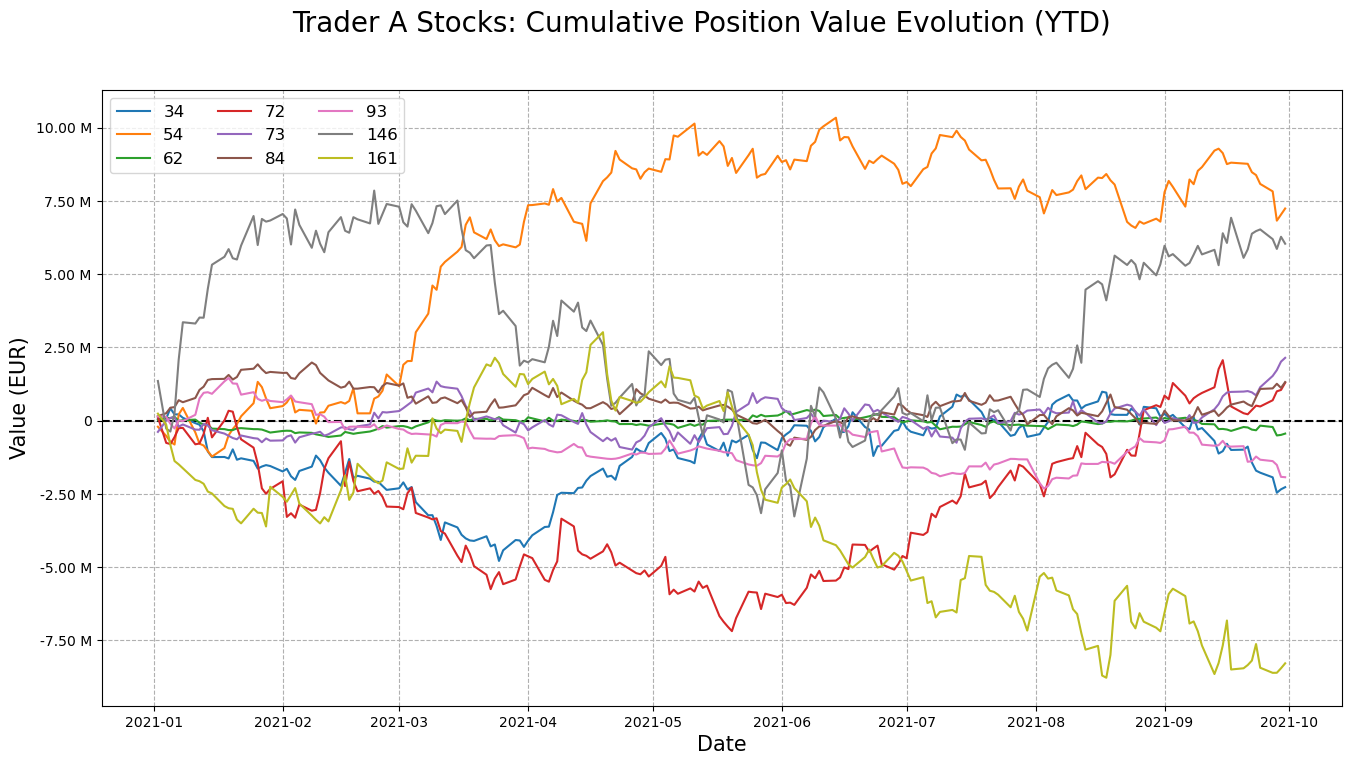

In [50]:
trader_A_cumulative_position_value_plot

##### `Trader A:  Total PnL Bar plot` - focus on winners, losers and the magnitudes

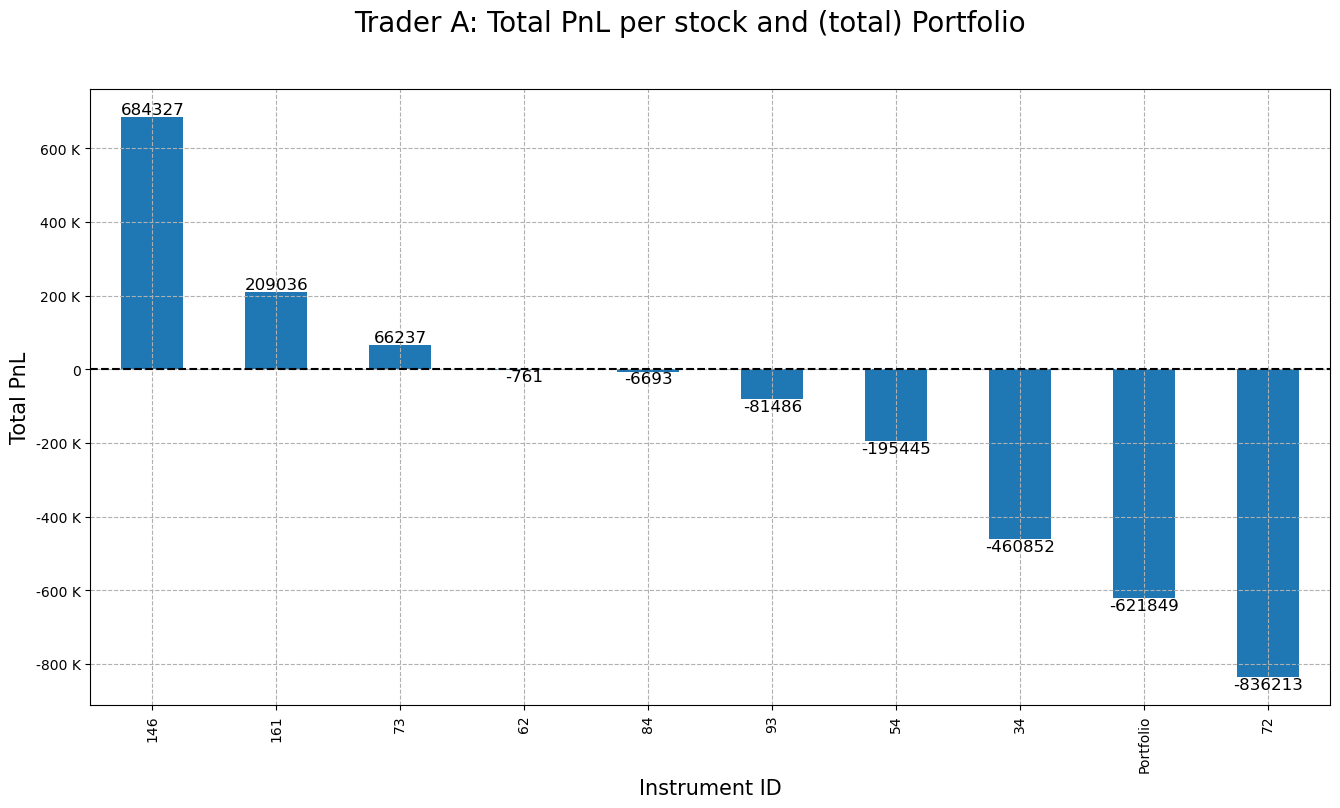

In [51]:
trader_A_total_pnl_per_stock_plot

##### `Trader A:  Annualized Sharpe Ratio Bar plot` - focus on risk adjusted performance of winners, losers and magnitudes

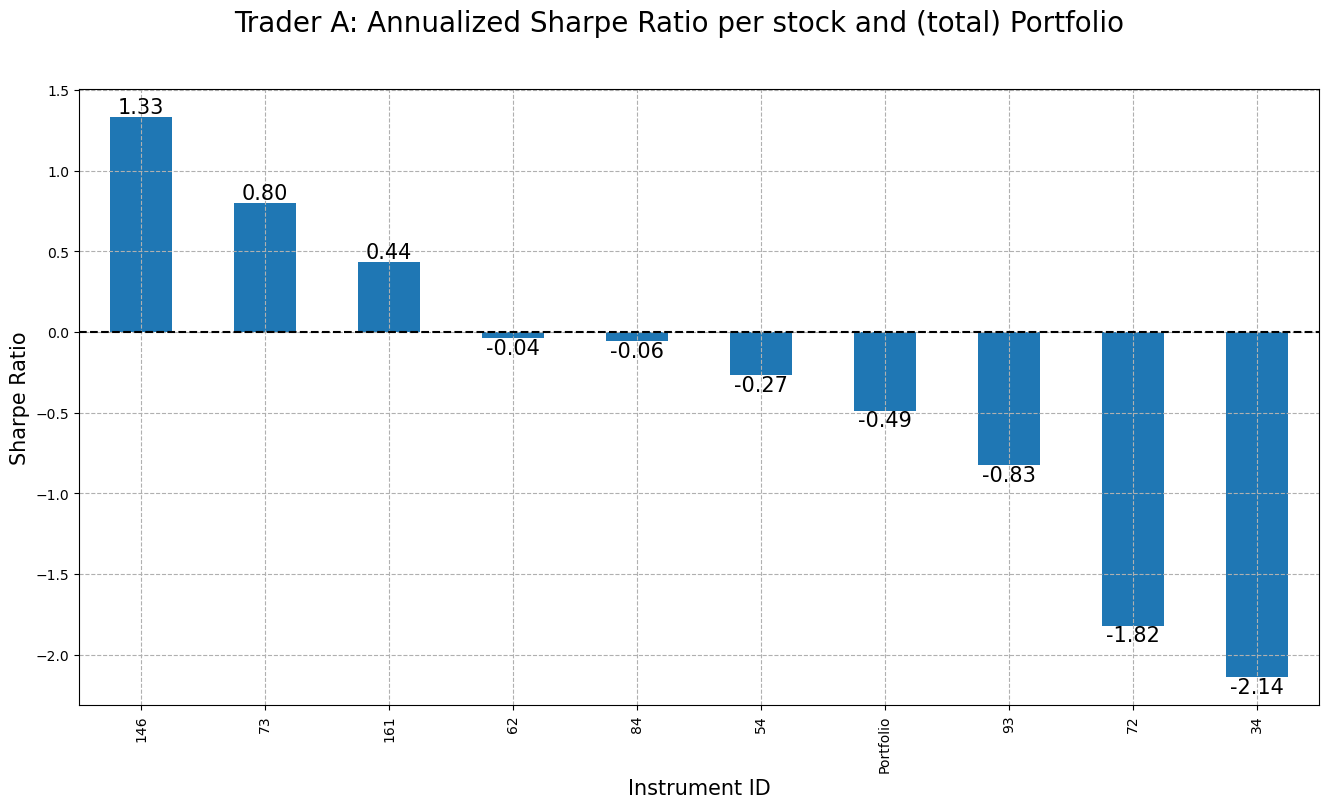

In [52]:
trader_A_sharpe_per_stock_plot

### `Trader B`
##### `Trader B:  Total PnL Evolution plot` - focus on winners, losers, volatility, any patterns / trends / strange occurings

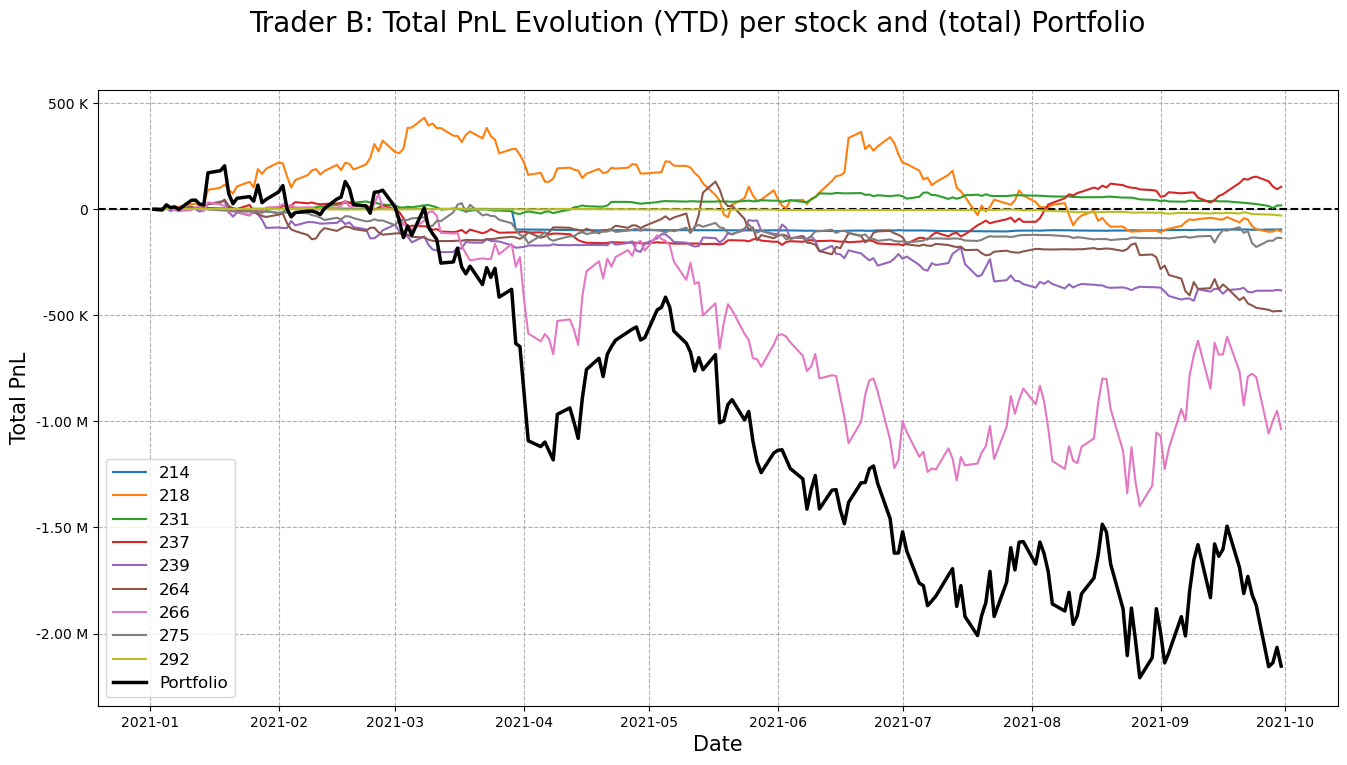

In [53]:
trader_B_cumulative_pnl_plot

##### `Trader B: Total Position Value Evolution plot` - variation in position, extreme positions, any pattern or strange / sudden event

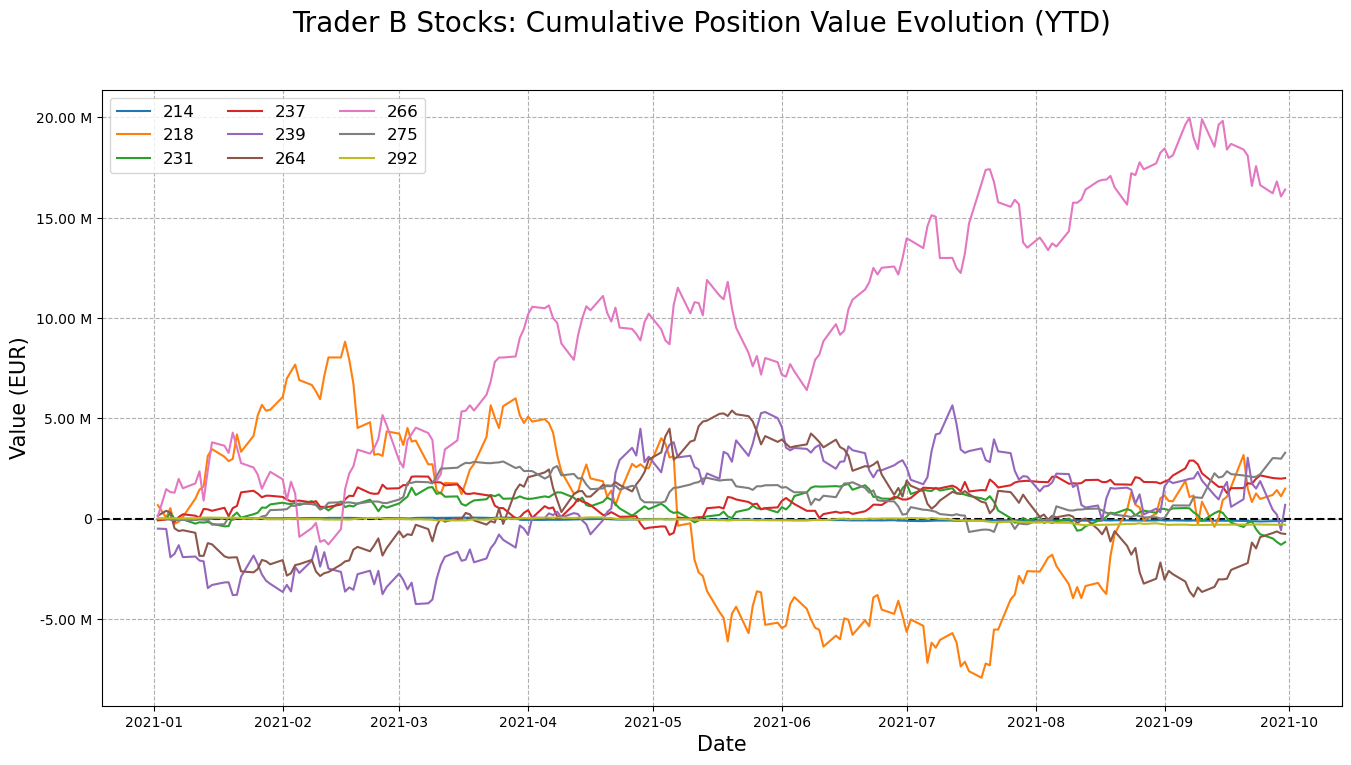

In [54]:
trader_B_cumulative_position_value_plot

##### `Trader B:  Total PnL Bar plot` - focus on winners, losers and the magnitudes

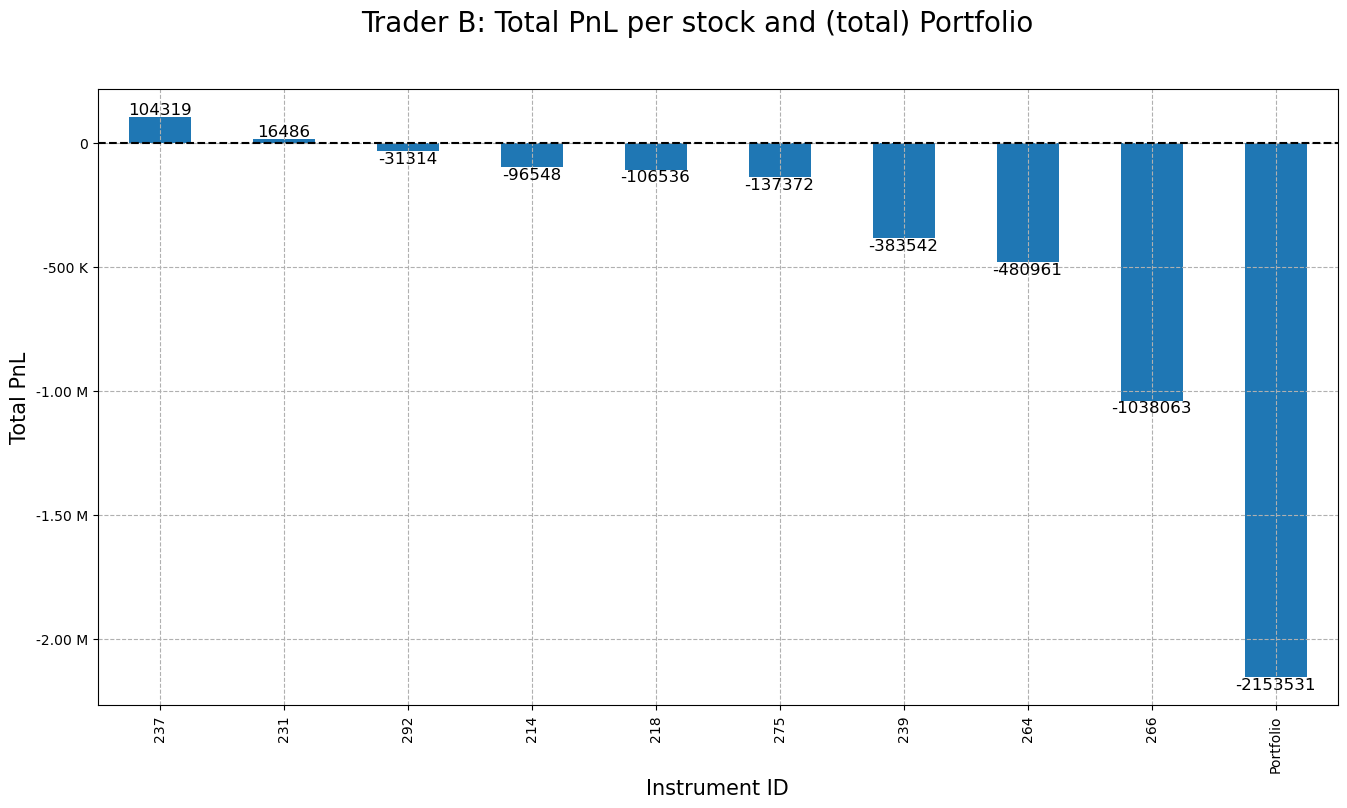

In [55]:
trader_B_total_pnl_per_stock_plot

##### `Trader B:  Annualized Sharpe Ratio Bar plot` - focus on risk adjusted performance of winners, losers and magnitudes

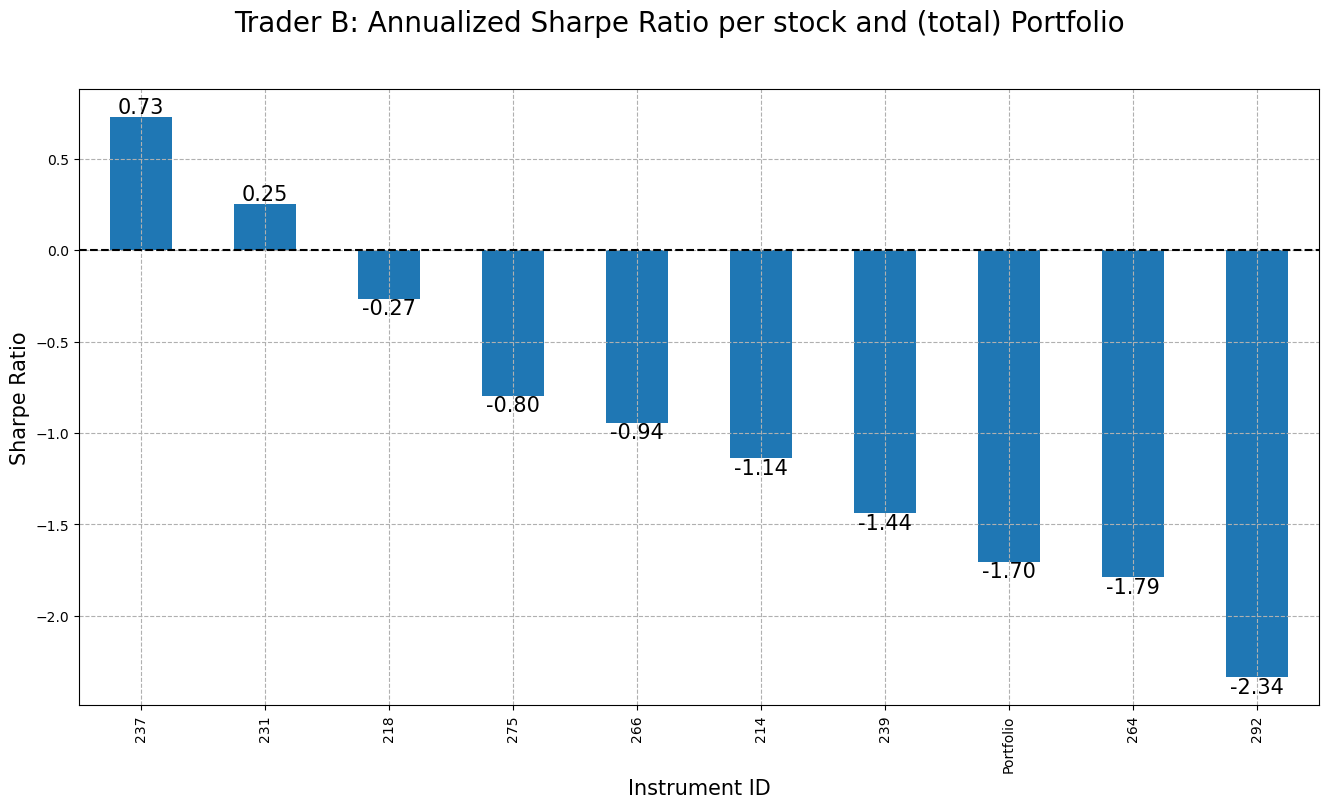

In [56]:
trader_B_sharpe_per_stock_plot

<a id='q2'></a>
# 6. `Question 2`
---
Based on your data exploration, what would you flag to the trader to pay extra attention to?

<a id='s2'></a>
> ## `Solution / Code`

##### Daily `returns` evolution of stocks - Trader A

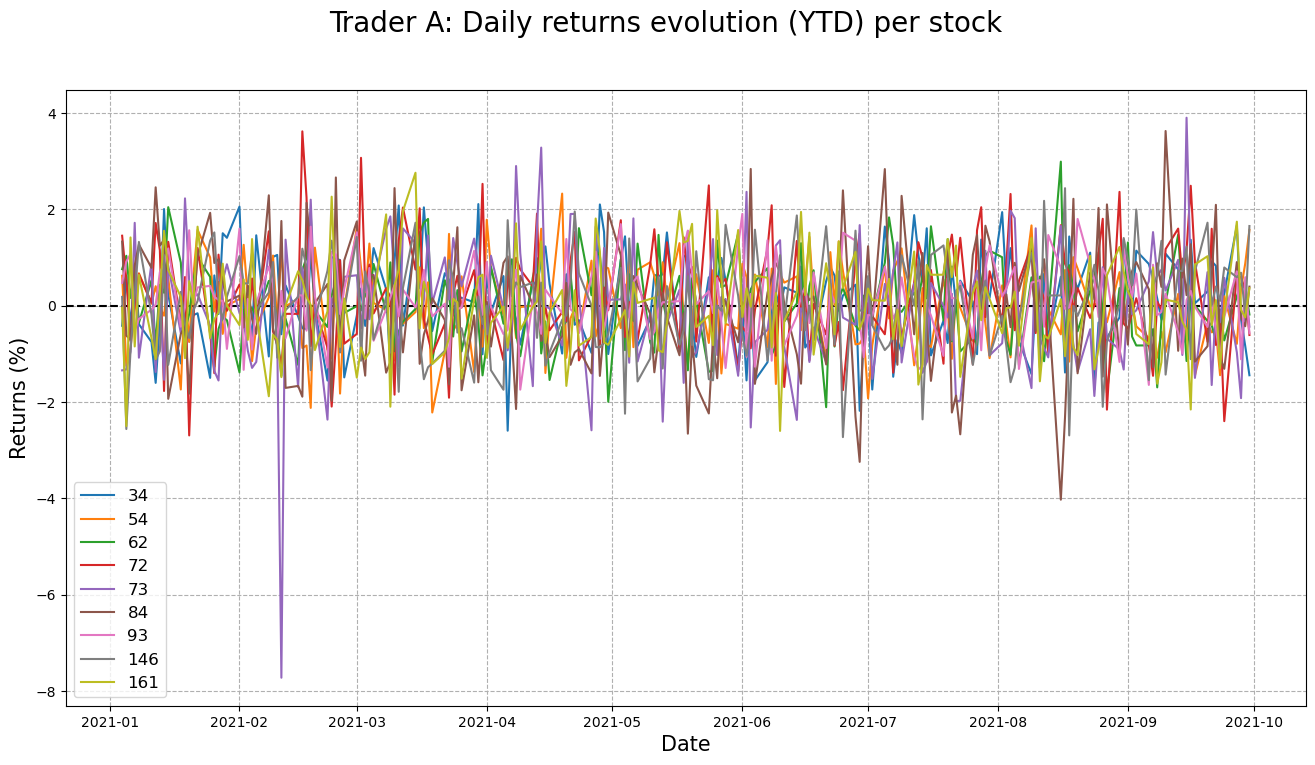

In [57]:
trader_A_stocks_return_evolution_plot, ax9 = plt.subplots(1, figsize = (16, 8))

trader_A_stocks_return_evolution_plot.suptitle('Trader A: Daily returns evolution (YTD) per stock', size = 20)
ax9.set_xlabel('Date', size = 15)
ax9.set_ylabel('Returns (%)', size = 15)
ax9.grid(True, linestyle = '--')

# zero line
ax9.axhline(0, color = 'k', linestyle = '--')

# plot daily returns
for stock in trader_A_stocks:
    ax9.plot(trader_A_performance_dict[stock]['daily pnl df']['close'].pct_change() * 100, label = f'{stock}')

ax9.legend(fontsize = 12);

##### Daily `returns` evolution of stocks - Trader B

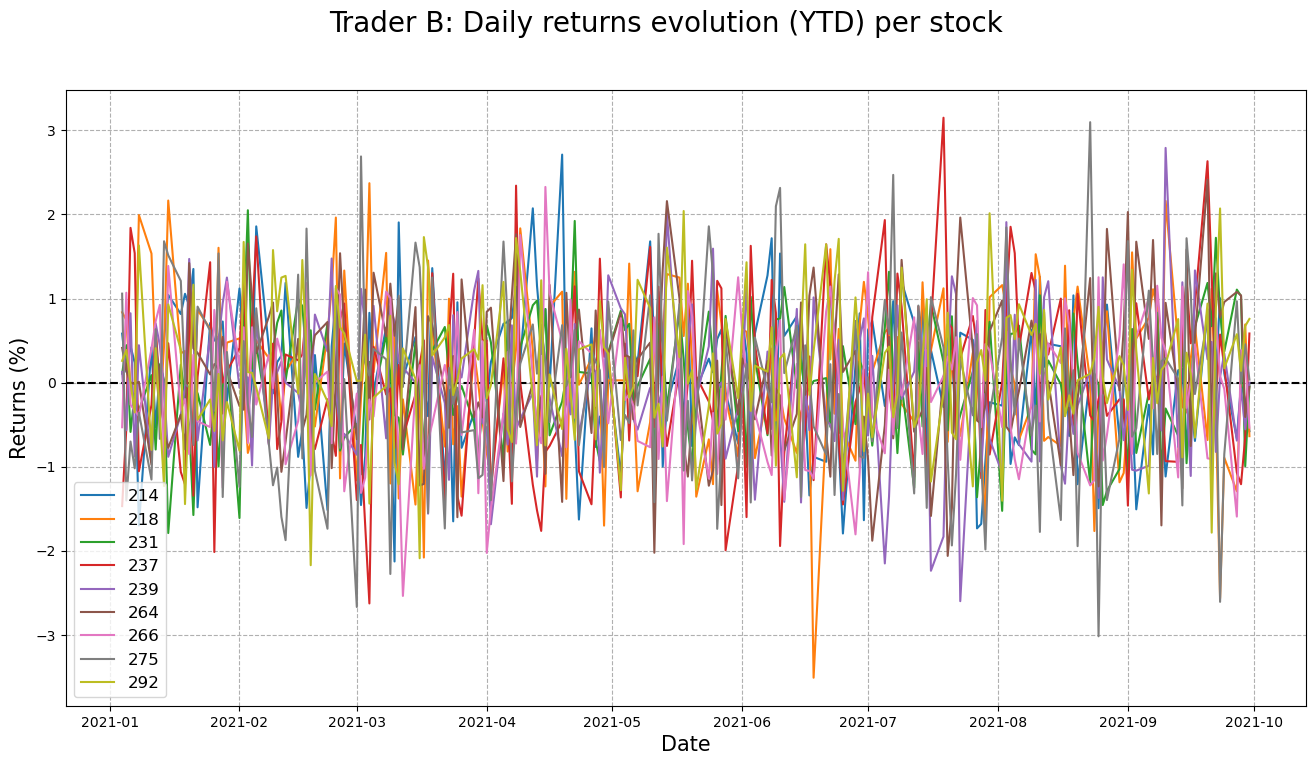

In [58]:
trader_B_stocks_return_evolution_plot, ax10 = plt.subplots(1, figsize = (16, 8))

trader_B_stocks_return_evolution_plot.suptitle('Trader B: Daily returns evolution (YTD) per stock', size = 20)
ax10.set_xlabel('Date', size = 15)
ax10.set_ylabel('Returns (%)', size = 15)
ax10.grid(True, linestyle = '--')

# zero line
ax10.axhline(0, color = 'k', linestyle = '--')

# plot daily returns
for stock in trader_B_stocks:
    ax10.plot(trader_B_performance_dict[stock]['daily pnl df']['close'].pct_change() * 100, label = f'{stock}')

ax10.legend(fontsize = 12);

##### Function to get proportion of trades being `market taking` in nature

In [59]:
def ratio_of_market_taking_trades(price, size, bid, ask):
    """
    Function to check if strategy is market-taking or market-making
    
    Inputs:
    ------
    price: series, price at which we traded
    size : series, how much did we buy / sell
    bid  : series, bid price during trade
    ask  : series, ask price during trade
    
    Returns:
    float, ratio of trades being market taking 
    """
    sell_rows = size < 0
    sell_price = price.loc[sell_rows]
    bid_at_sell = bid.loc[sell_rows]
    
    buy_rows = size > 0
    buy_price = price.loc[buy_rows]
    ask_at_buy = ask.loc[buy_rows]
    
    market_taking_ratio_during_sell = (bid_at_sell == sell_price).mean()
    market_taking_ratio_during_buy = (ask_at_buy == buy_price).mean()
    
    return (market_taking_ratio_during_buy * len(buy_price) + \
            market_taking_ratio_during_sell * len(sell_price)) / (len(buy_price) + len(sell_price))

##### Function to check if our `theoretical price` is always between `bid price` and `ask price`

In [60]:
def check_if_theo_in_between_of_bid_and_ask(theo, bid, ask):
    """
    Function to check if theo price is b/w of bid and ask prices
    
    Inputs:
    ------
    theo: pandas series
    bid : pandas series
    ask : pandas series
    
    Returns:
    -------
    True if theo is always between bid and ask, else False
    """
    return all(theo.between(bid, ask))

<a id='a2'></a>
## `Answer 2`
>
> **`Part 1`**: Look at metrics and explicitly know <u>_**which**_</u> stocks are performing bad / need extra attention. For this purpose:
>> ##### For  both the Traders, I show them the following:
>> - Metrics like `Total PnL`, `Sharpe`, `Volatility`, `Maximum drawdown`, `% Win days` along with their relative rankings. This will straight away let traders know which stocks are going wrong and what are the potential reasons for them going wrong.
>> - Also, focus on any extreme / weird `positions` that traders may end up taking (knowingly or unknowingly) in their instruments. I have put `Total Position Value Evolution Plots` for both the traders in [Answer 1](#a1) section for this purposes.
>
> **`Part 2`**: Extract insights from data as to possibly <u>_**why**_</u> the performance is good or bad. For this purpose:
>> - Is the portfolio performing badly because `prices` move wildly / unexpectedly which is not accounted for by our algorithms? If not, then there is a fundamental issue with our strategy / algorithm (our `hypothesis` about the stock and the market is wrong) which needs to be addressed.
>> - Is our strategy `market-taking` or `market-making`?
>> - Is `theoretical price` always between the current `bid price` and `ask price`? This will help us see if we are doing positive `expected value` trades (e.g. if we are taking markets and theo is always between bid and ask, then we are doing negative EV trades). See [(Possibly) Interesting Insight: Why Bad Are Stocks Doing Badly?](#insight)
>
> ##### Can also be analysed:
>> - Analyse within a particular subset of stocks e.g. same `country`, `currency` or `industry sub-group`. Is there any significant correlation within a subset (e.g. stocks of a particular country performed horribly)? Is there any relationship between different groupings (e.g. one goes up, another goes down)? etc.

This set of analysis is by no means exhaustive as there are many other data points and patterns / links to analyse. I discuss some extra ideas in [Scope for Further Analysis and Improvement](#scope).

### `Part 1`: Look at metrics and explicitly know <u>_**which**_</u> stocks are performing bad / need extra attention

##### For both `Trader A` and `Trader B` performance is summarised across stocks and (total) portfolio
- Again, don't forget to check `Total Position Evolution Plot` in [Answer 1](#a1) to see if traders end up with weird / extreme `positions` in their instruments
- For sure pay attention to stocks (a) having negative values AND (b) in bottom quantiles for `PnL` and `Sharpe`
- Other metrics like `Volatility`, `Maximum Drawdown` and `% Win days` also help the traders to know in what **effect** is portfolio performing badly but they don't necessarily give the reason **why (cause)**. For example - 
    - Why (cause) is volatility (effect) high?
    - Why (cause) is Sharpe (effect) negative?
    
We try to analyse the `causal factors` in `Part 2` of this answer.

- ##### `Trader A` performance across stocks (judged and ranked on different metrics)

In [61]:
trader_A_performance_df

total pnl total pnl rank sharpe sharpe rank volatility  \
146        684326.89              1   1.33           1  663821.26   
161        209035.97              2   0.44           3  620828.90   
73          66237.14              3   0.80           2  107047.17   
62           -760.81              4  -0.04           4   24846.13   
84          -6693.21              5  -0.06           5  156797.68   
93         -81485.53              6  -0.83           8  127492.14   
54        -195444.87              7  -0.27           6  936980.30   
34        -460851.85              8  -2.14          10  278184.71   
Portfolio -621849.14              9  -0.49           7 1647558.21   
72        -836212.86             10  -1.82           9  593597.19   

          volatility rank max drawdown max drawdown rank % win days  \
146                     8    602043.28                 7       0.53   
161                     7    514940.16                 5       0.49   
73                      2     80161.85                 2       0.51   
62                      1     26065.01                 1       0.51   
84                      4    163842.84                 3       0.48   
93                      3    186960.26                 4       0.49   
54                      9   1154860.32                 9       0.49   
34                      5    564749.58                 6       0.45   
Portfolio              10   2265520.92                10       0.48   
72                      6    938793.28                 8       0.47   

          % win days rank  
146                     1  
161                     4  
73                      2  
62                      3  
84                      8  
93                      5  
54                      5  
34                     10  
Portfolio               7  
72                      9

- ##### `Trader B` performance across stocks (judged and ranked on different metrics)

In [62]:
trader_B_performance_df

total pnl total pnl rank sharpe sharpe rank volatility  \
237         104318.80              1   0.73           1  185505.55   
231          16485.84              2   0.25           2   84076.32   
292         -31313.93              3  -2.34          10   17329.77   
214         -96547.98              4  -1.14           6  109527.23   
218        -106536.48              5  -0.27           3  519333.62   
275        -137371.66              6  -0.80           4  223254.65   
239        -383541.80              7  -1.44           7  344965.60   
264        -480961.28              8  -1.79           9  347868.34   
266       -1038062.87              9  -0.94           5 1422736.28   
Portfolio -2153531.36             10  -1.70           8 1634034.66   

          volatility rank max drawdown max drawdown rank % win days  \
237                     4    207114.68                 5       0.50   
231                     2     73033.35                 2       0.45   
292                     1     32630.06                 1       0.41   
214                     3    108092.27                 3       0.48   
218                     8    539669.45                 7       0.52   
275                     5    206675.88                 4       0.49   
239                     6    470027.37                 6       0.44   
264                     7    611659.42                 8       0.47   
266                     9   1470658.06                 9       0.48   
Portfolio              10   2411022.18                10       0.51   

          % win days rank  
237                     3  
231                     8  
292                    10  
214                     5  
218                     1  
275                     4  
239                     9  
264                     7  
266                     5  
Portfolio               2

### `Part 2`: Extract insights from data as to possibly <u>_**why**_</u> the performance is good or bad

##### Are prices moving unexpectedly which is not accounted by our algorithms?
- ##### `Trader A`: Daily returns evolution plot
    - Returns look reasonable and not too 'wild' except few cases. This means prices for Trader A stocks are not haywire. But Trader A looses money on most of the stocks. This means there is an fundamental issue with their strategies / algorithms (hypothesis about the stock and the market is wrong) which needs to be addressed.

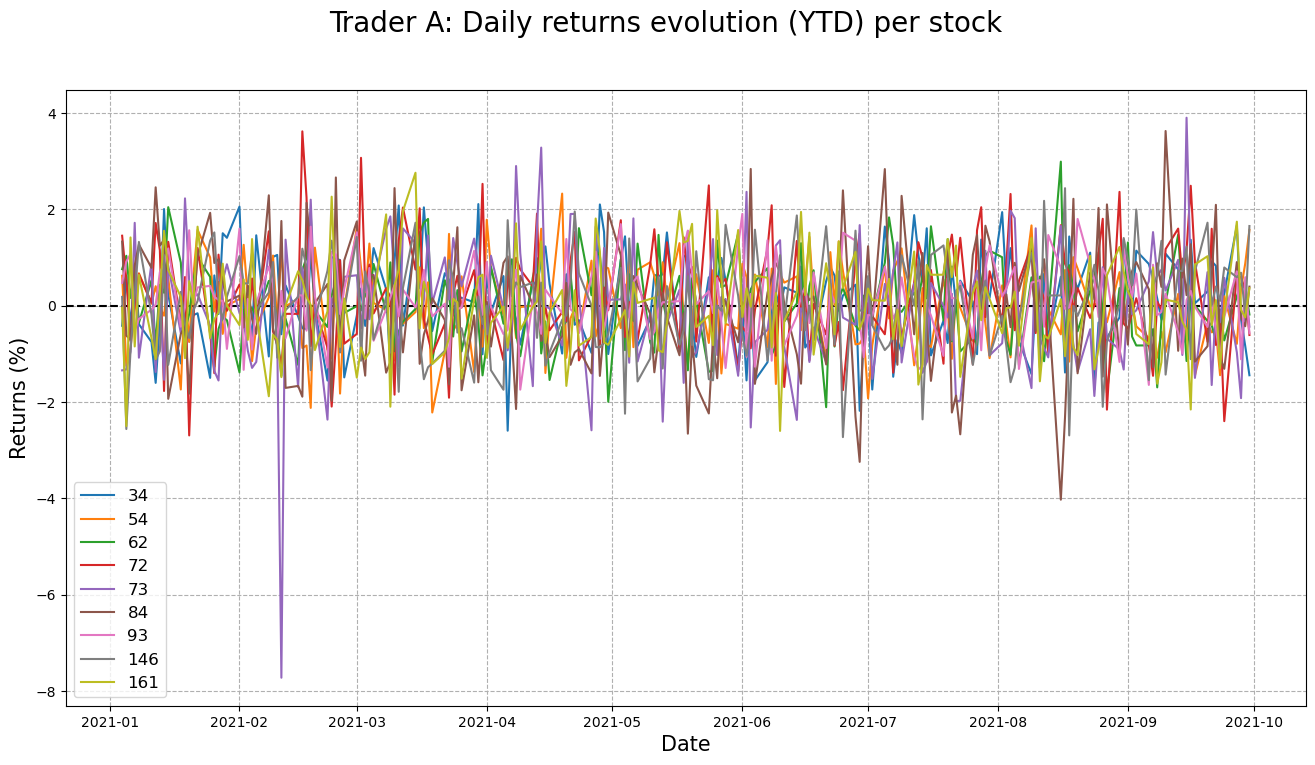

In [63]:
trader_A_stocks_return_evolution_plot

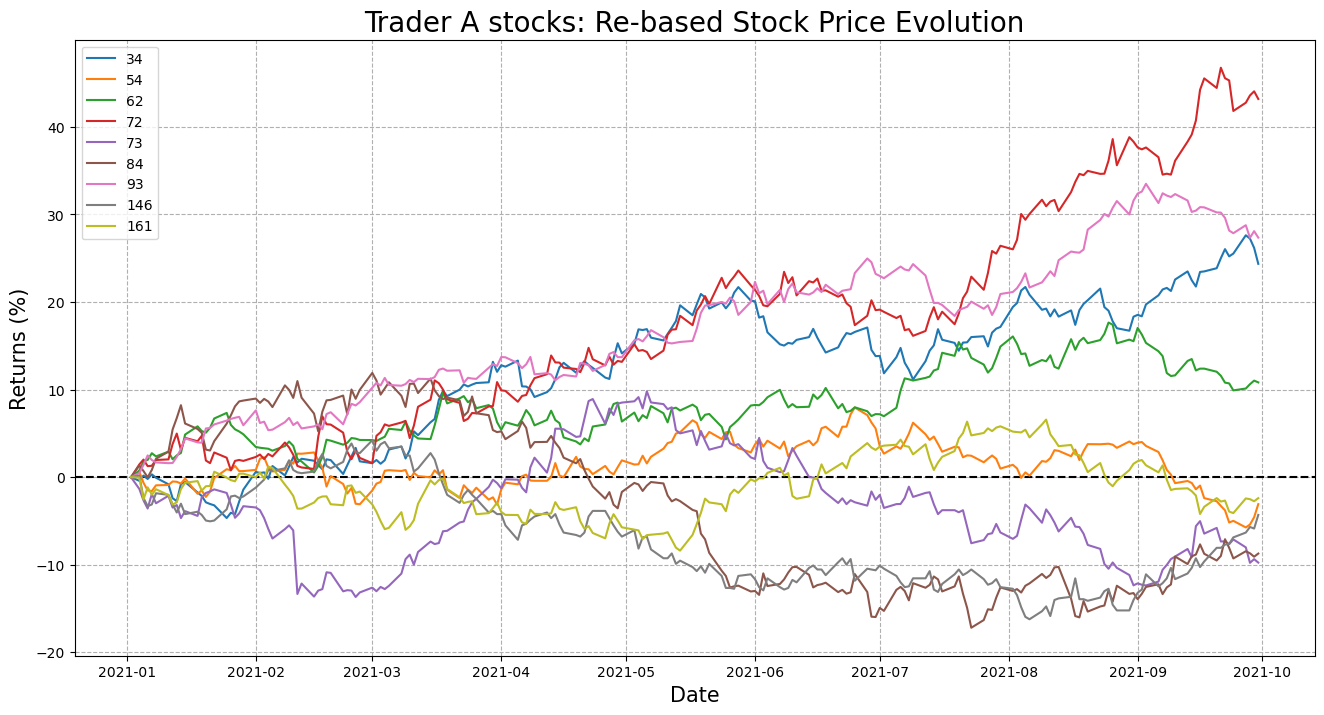

In [64]:
plt.figure(figsize = (16, 8))

plt.title('Trader A stocks: Re-based Stock Price Evolution', size = 20)
plt.xlabel('Date', size = 15)
plt.ylabel('Returns (%)', size = 15)
plt.grid(True, linestyle = '--')

# zero line
plt.axhline(0, color = 'k', linestyle = '--')

for stock in trader_A_stocks:
    plt.plot((trader_A_performance_dict[stock]['daily pnl df']['close'] / \
              trader_A_performance_dict[stock]['daily pnl df']['close'][0] - 1) * 100, label = stock)
    
plt.legend();

- ##### `Trader B`: Daily returns evolution plot
    - Returns look reasonable and not too 'wild' except few cases. This means prices for Trader B stocks are not haywire. But Trader B looses money on most of the stocks. This means there is an fundamental issue with their strategies / algorithms (hypothesis about the stock and the market is wrong) which needs to be addressed.

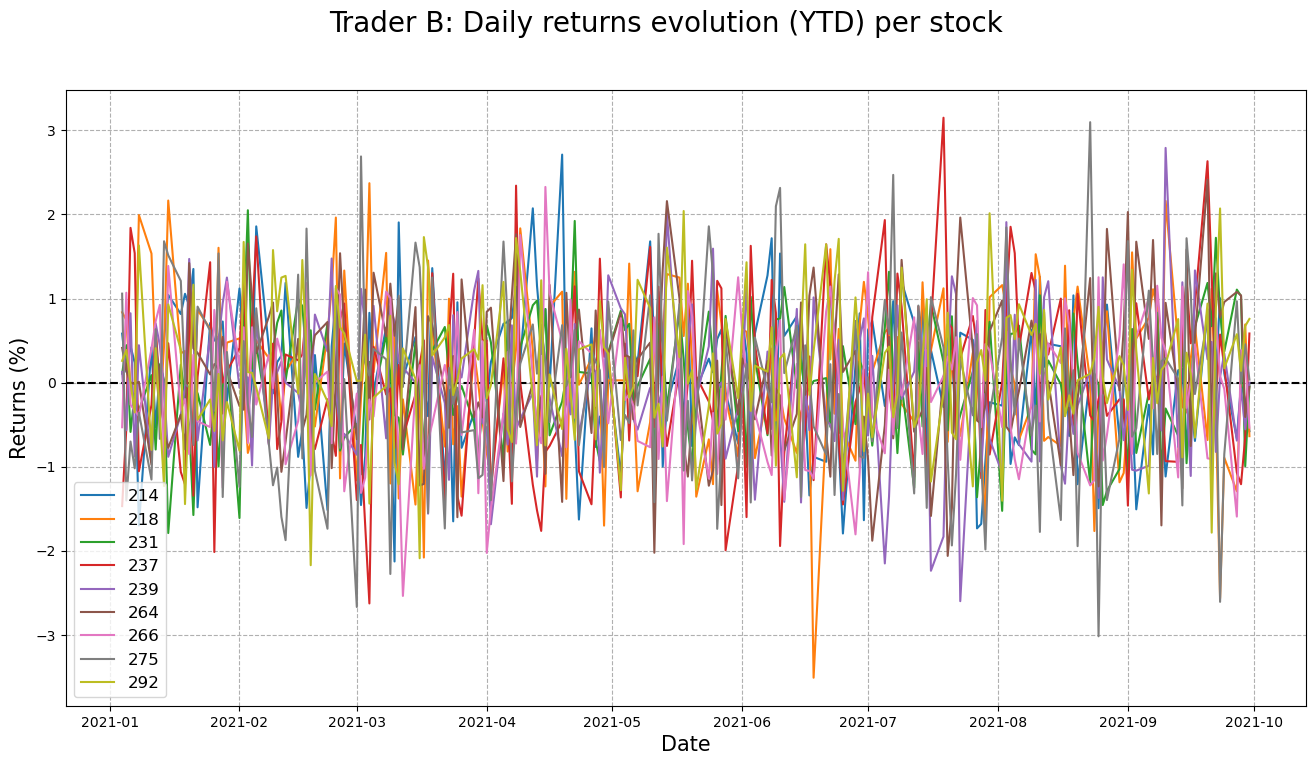

In [65]:
trader_B_stocks_return_evolution_plot

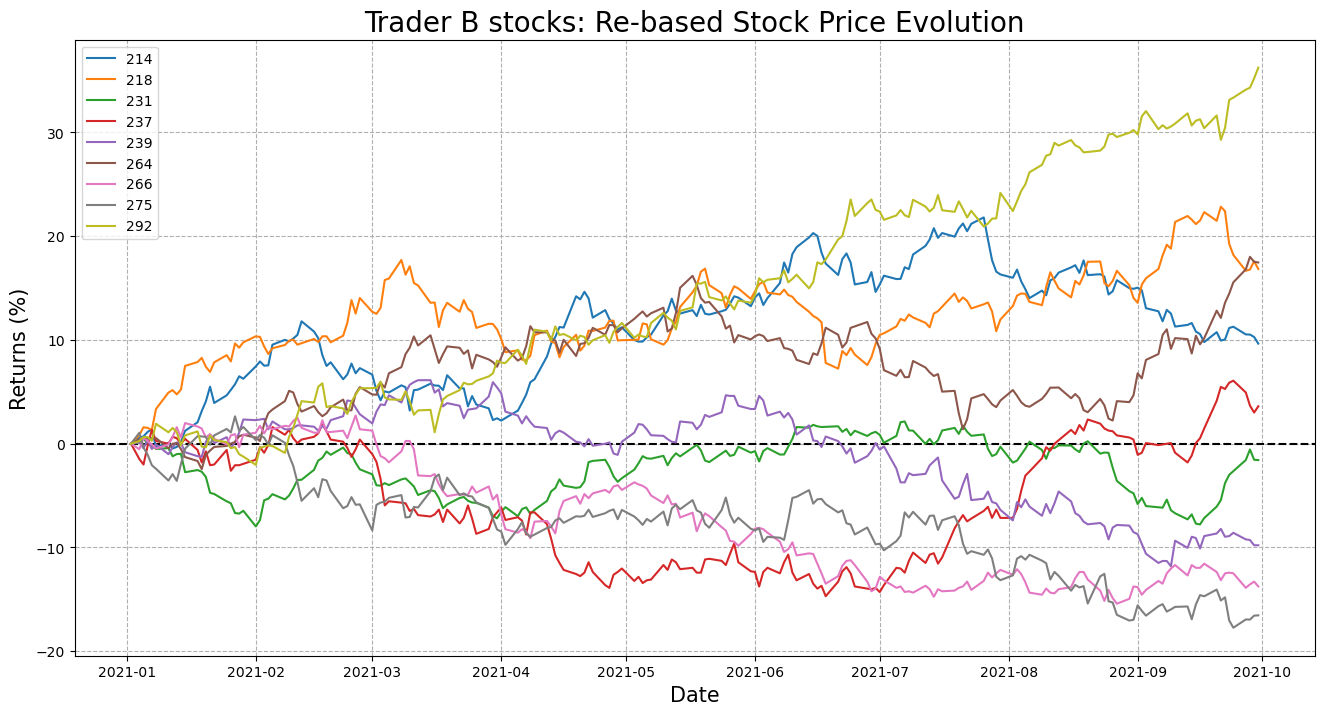

In [66]:
plt.figure(figsize = (16, 8))

plt.title('Trader B stocks: Re-based Stock Price Evolution', size = 20)
plt.xlabel('Date', size = 15)
plt.ylabel('Returns (%)', size = 15)
plt.grid(True, linestyle = '--')

# zero line
plt.axhline(0, color = 'k', linestyle = '--')

for stock in trader_B_stocks:
    plt.plot((trader_B_performance_dict[stock]['daily pnl df']['close'] / \
              trader_B_performance_dict[stock]['daily pnl df']['close'][0] - 1) * 100, label = stock)
    
plt.legend();

##### What could be wrong with the algorithms? Are they doing negative `expected value` trades?
Let's check this for an instrument (say `instrument_id` $= 34$) 

- What proportion of trades executed by strategy in `instrument_id` is market taking in nature?
- Is `theoretical price` always between `bid price` and `ask price` for `instrument_id`?

_If the nature of our strategy is more `market taking` in nature and `Theo` is always between `Bid` and `Ask` then this means we are doing more of negative `expected value` trades._

In [67]:
instrument_id = 34

trade_rows = firm_transactions_df.loc[instrument_id].index
theo = theoretical_prices_df.loc[instrument_id].loc[trade_rows, 'theo']
bid = market_data_df.loc[instrument_id].loc[trade_rows, 'bid_price']
ask = market_data_df.loc[instrument_id].loc[trade_rows, 'ask_price']
trade_price = firm_transactions_df.loc[instrument_id]['price']
trade_size = firm_transactions_df.loc[instrument_id]['size']
total_pnl = trader_A_daily_pnl_df[instrument_id].sum()

ratio_market_taking = ratio_of_market_taking_trades(trade_price, trade_size, bid, ask) * 100
print(f'Ratio of trades being market taking in nature  = {ratio_market_taking:.1f}%')

is_theo_between_bid_and_ask = check_if_theo_in_between_of_bid_and_ask(theo, bid, ask)
print(f'Is Theo always between Bid price and Ask price = {is_theo_between_bid_and_ask}')
print(f'Total PnL over window (YTD) for the instrument = {total_pnl:.0f}')

Ratio of trades being market taking in nature  = 75.2%
Is Theo always between Bid price and Ask price = True
Total PnL over window (YTD) for the instrument = -460852


<a id='insight'></a>
### `(Possibly) Interesting Insight: Why Bad Stocks Are Doing Badly?`

- **Reiterating**: _If our strategy is more `market taking` in nature and `Theo` is always between `Bid` and `Ask` then this means we are doing more of negative `expected value` trades._
- This relation can be seen - higher the proportion of market trading trades AND theo being in between of bid and ask, the more negative is our PnL
- This means the strategy and algorithm is fundamentally flawed

_**Note:** Negative `EV` trades don't necessarily imply that we will end up losing money. `Expectation` is negative but `Realized` outcome may or may not be negative. Also, data is autogenerated with unknown `Data Generating Process` so we cannot be fully sure._

In [68]:
insight_df = pd.DataFrame(columns = ['% market taking', 'theo in b/w', 'total pnl'],
                          index = trader_A_stocks)

for instrument_id in trader_A_stocks:

    trade_rows = firm_transactions_df.loc[instrument_id].index
    theo = theoretical_prices_df.loc[instrument_id].loc[trade_rows, 'theo']
    bid = market_data_df.loc[instrument_id].loc[trade_rows, 'bid_price']
    ask = market_data_df.loc[instrument_id].loc[trade_rows, 'ask_price']
    trade_price = firm_transactions_df.loc[instrument_id]['price']
    trade_size = firm_transactions_df.loc[instrument_id]['size']

    ratio_market_taking = ratio_of_market_taking_trades(trade_price, trade_size, bid, ask) * 100
    is_theo_between_bid_and_ask = check_if_theo_in_between_of_bid_and_ask(theo, bid, ask)
    total_pnl = trader_A_daily_pnl_df[instrument_id].sum()
    
    insight_df.loc[instrument_id] = [ratio_market_taking, is_theo_between_bid_and_ask, total_pnl]
    

insight_df.sort_values(['% market taking'])

% market taking theo in b/w  total pnl
93            12.81        True  -81485.53
73            13.10        True   66237.14
146           19.46        True  684326.89
62            35.14        True    -760.81
161           38.92        True  209035.97
84            39.76        True   -6693.21
72            53.63        True -836212.86
54            71.25        True -195444.87
34            75.21        True -460851.85

In [69]:
corr, p_value = stats.pearsonr(insight_df['% market taking'], insight_df['total pnl'])
print(f"Correlation between 'ratio of market taking' and 'total pnl' = {corr:.2f}  (p-value = {p_value:.2f})")

Correlation between 'ratio of market taking' and 'total pnl' = -0.61  (p-value = 0.08)


<a id='q3'></a>
# 7. `Question 3`
---
Present your thoughts on which portfolio does best and why, using any metrics and statistics that you think sensible? 

<a id='s3'></a>
> ## `Solution / Code`
> Here we write a function to evaluate Traders A $\&$ B by comparing their portfolio's performance using different statistics and tests.

##### Define a function `compare_performance` to compare 2 traders portfolio performance

In [70]:
def compare_performance(trader_A_portfolio_daily_pnl, 
                        trader_B_portfolio_daily_pnl,
                        annual_trading_days = 252):
    """
    This function compares 2 traders (A & B)'s performance based on their Portfolio's daily PnL
    
    Inputs:
    -------
    trader_A_portfolio_daily_pnl : pandas series of trader A portfolio's daily PnL
    trader_B_portfolio_daily_pnl : pandas series of trader B portfolio's daily PnL
    annual_trading_days          : number of trading days in a year, default = 252
    
    We compare on the basis of:
    ---------------------------
    1. Total PnL
    2. Annualized Sharpe Ratio (also test if difference is statistically significant)
    3. Annualized Volatility (also test if difference is statistically significant)
    4. % Win days
    5. Maximum drawdown
    
    In the end, we also test assumptions needed for significance tests
    
    """
    
    def print_comparison(metric, A_metric, B_metric, precision, higher_is_better = True):
        """Helper function to print comparison"""
        
        print()
        print(f'========================== {metric} comparison ==========================')
        print(f'Trader A: {A_metric:.{precision}f}')
        print(f'Trader B: {B_metric:.{precision}f}', '\n')

        if (A_metric > B_metric) and higher_is_better:
            print(f'Trader A was better','\n')
        elif (A_metric < B_metric) and higher_is_better:
            print(f'Trader B was better','\n')
        elif (A_metric > B_metric) and not(higher_is_better):
            print(f'Trader B was better','\n')
        else:
            print(f'Trader A was better','\n')
            
            
    def maximum_drawdown(series):
        """Helper function to calculate maximum drawdown of a pandas series"""
        cumulative = series.cumsum()
        roll_min_idx = np.argmax(np.maximum.accumulate(cumulative) - cumulative)
        roll_max_idx = np.argmax(cumulative[:roll_min_idx])
        
        return cumulative[roll_max_idx] - cumulative[roll_min_idx]
            
    
    def check_normality_and_iid(trader, pnl_series):
        """Helper function to check normality and iid assumptions for tests"""
        
        print(f"======= {trader}: Daily PnL normality and i.i.d. assumptions check ========", '\n')

        print(f'Normality checks:', '\n')
        print(f'Skewness   = {stats.skew(pnl_series):.2f}')
        print(f'Kurtosis   = {stats.kurtosis(pnl_series, fisher = False):.2f}')
        normality_p_value = stats.jarque_bera(pnl_series)[-1]
        print(f'JB p-value = {normality_p_value:.2f}', '\n')

        print(f'i.i.d checks:')
        print(f'Autocorrelation plot (below)')
        plt.figure(figsize = (6, 2))
        pd.plotting.autocorrelation_plot(pnl_series, marker = 'o').set_xlim([0, 15])
        plt.legend([trader])
        plt.grid(True, linestyle = '--');
            
        
    # total pnl
    trader_A_total_pnl = trader_A_portfolio_daily_pnl.sum()
    trader_B_total_pnl = trader_B_portfolio_daily_pnl.sum()
    print_comparison(' Total PnL', trader_A_total_pnl, trader_B_total_pnl, 0)    
    
    
    # sharpe
    trader_A_sharpe = np.sqrt(annual_trading_days) * (trader_A_portfolio_daily_pnl.mean() / \
                                                      trader_A_portfolio_daily_pnl.std())
    trader_B_sharpe = np.sqrt(annual_trading_days) * (trader_B_portfolio_daily_pnl.mean() / \
                                                      trader_B_portfolio_daily_pnl.std())
    print_comparison('Ann Sharpe', trader_A_sharpe, trader_B_sharpe, 2)
    
    
    # signifiance test on sharpe by Welch's t-test
    _, p_value = stats.ttest_ind(trader_A_portfolio_daily_pnl, 
                                 trader_B_portfolio_daily_pnl, 
                                 equal_var = False)
    print(f"Sharpe difference significance test: Welch's t-test")
    
    if p_value >= 0.05:
        print(f'p-value = {p_value:.2f}, difference not significant at 5% level','\n')
    else:
        print(f'p-value = {p_value:.2f}, difference significant at 5% level','\n')
        
    
    # volatility
    trader_A_vol = np.sqrt(annual_trading_days) * trader_A_portfolio_daily_pnl.std()
    trader_B_vol = np.sqrt(annual_trading_days) * trader_B_portfolio_daily_pnl.std()
    print_comparison('Volatility', trader_A_vol, trader_B_vol, 0, False)
    
    
    # signifiance test on volatility by Levene's test
    _, p_value = stats.levene(trader_A_portfolio_daily_pnl, 
                              trader_B_portfolio_daily_pnl, 
                              center = 'mean')
    print(f"Volatility difference significance test: Levene's test")
    
    if p_value >= 0.05:
        print(f'p-value = {p_value:.2f}, difference not significant at 5% level','\n')
    else:
        print(f'p-value = {p_value:.2f}, difference significant at 5% level','\n')
        
        
    # win ratio
    trader_A_win_ratio = (trader_A_portfolio_daily_pnl > 0).mean() * 100
    trader_B_win_ratio = (trader_B_portfolio_daily_pnl > 0).mean() * 100
    print_comparison('% Win days', trader_A_win_ratio, trader_B_win_ratio, 1)
    

    # maximum drawdown
    trader_A_max_dd = maximum_drawdown(trader_A_portfolio_daily_pnl)
    trader_B_max_dd = maximum_drawdown(trader_B_portfolio_daily_pnl)
    print_comparison('Max Drawd.', trader_A_max_dd, trader_B_max_dd, 0, False)
    print('\n')
    
    
    # check normality and iid assumptions
    check_normality_and_iid('Trader A', trader_A_portfolio_daily_pnl)
    print('\n')
    check_normality_and_iid('Trader B', trader_B_portfolio_daily_pnl)
    print('\n')
    
    
    # correlation between Trader A and Trader B
    print(f'========= Correlation between Trader A and Trader B Performance ===========')
    correlation, p_value = stats.pearsonr(trader_A_portfolio_daily_pnl, trader_B_portfolio_daily_pnl)
    print(f'Correlation coefficient = {correlation:.2f}')
    print(f'Correlation p-value     = {p_value:.2f}', '\n')
    
    
    print('\n')
    print(f'===========================================================================')
    print('\n')

<a id='a3'></a>
## `Answer 3`
>
> ##### For both the Traders, I compare their (total) Portfolio performance using:
>> - **Total PnL**: How much money did the portfolio make or loose matters
>> - **(Annualized) Sharpe ratio**: To evaluate if `risk` taken on by the portfolio was justified
>>     - Perform statistical test on difference of Sharpe by `Welch's t-test of equal means` using `scipy.stats`
>> - **(Annualized) volatility**: To evaluate consistency of the portfolio's performance
>>     - Perform statistical test on difference of volatilities by `Levene's test of equal variances` using `scipy.stats`
>> - **$\%$ Win days**: To get an idea of proportion of times the portfolio does good
>> - **Maximum drawdown**: To get an idea of maximum downside risk possible of the portfolio
>
> ##### Can also compare
>> - **Maximum winning streak**
>> - **Maximum loosing streak**

There are some metrics where `Trader A` fares better than `Trader B` and vice-versa.

I would say <u>**`Trader A` is BETTER than `Trader B` overall**</u> as `Trader A` has higher `Sharpe` and `Total PnL`. These $2$ metrics are relatively more important as they indicate the amount of money made (lost) and the risk / stability / consistency with which that money was made (lost). `Sharpe` and `Total PnL` are also where the values differ relatively more (in favour of `Trader A`) as compared to other metrics. Also, `Trader A` has marginally lower `Maximum Drawdown` as compared to `Trader B`. The difference in `Volatility` and `% Win days` values is very less between both the traders.

Though, **on an `absolute` level both the traders did poorly** as they lost 'decent' sum of money. Such observed results are maybe the consequence of auto-generated data of this assignment.

In the end, we test for **`normality`** assumption through `skewness`, `kurtosis` and `Jarque Bera` test. We also test for **`independent and identical distribution (iid)`** assumption through `autocorrelation` and cross-correlations. These assumptions check are to see if we can rely on our `significance tests` results. For both the traders, we see that their daily PnL is roughly normally distributed and with large number of samples **`central limit theorem`** also helps to rely on results of our tests.


==========================  Total PnL comparison ==========================
Trader A: -621849
Trader B: -2153531 

Trader A was better 


========================== Ann Sharpe comparison ==========================
Trader A: -0.49
Trader B: -1.70 

Trader A was better 

Sharpe difference significance test: Welch's t-test
p-value = 0.45, difference not significant at 5% level 


========================== Volatility comparison ==========================
Trader A: 1647558
Trader B: 1634035 

Trader B was better 

Volatility difference significance test: Levene's test
p-value = 0.70, difference not significant at 5% level 


========================== % Win days comparison ==========================
Trader A: 48.2
Trader B: 51.3 

Trader B was better 


========================== Max Drawd. comparison ==========================
Trader A: 2265521
Trader B: 2411022 

Trader A was better 



======= Trader A: Daily PnL normality and i.i.d. assumptions check ======== 

Normality checks: 

Ske

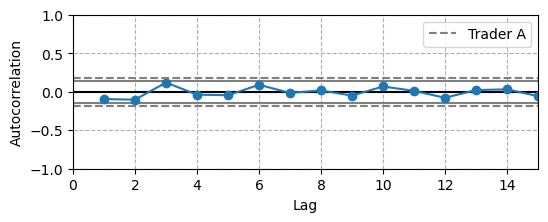

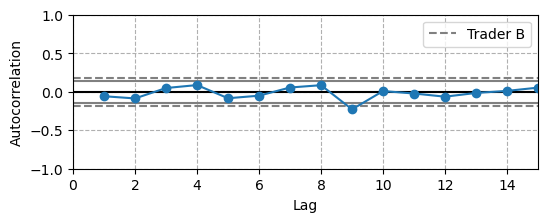

In [71]:
trader_A_portfolio_daily_pnl = trader_A_daily_pnl_df['Portfolio']
trader_B_portfolio_daily_pnl = trader_B_daily_pnl_df['Portfolio']

compare_performance(trader_A_portfolio_daily_pnl, trader_B_portfolio_daily_pnl)

<a id='scope'></a>
# 8. `Scope for Further Analysis and Improvement`
---
#### `Code`
> - _Code can be made more modular, dynamic (automated), robust and efficient_
> - _Readability and structure can also be improved_

#### `Results`
> - _Plots can be made more structured and viewer friendly_
> - _Presentation (e.g. showing plot vs numeric values) and structure of solution_

#### `Other ideas to explore`
> - _Correlation between different instruments / groups for `statistical arbitrage` purposes_
> - _`Volume Order Imbalance (VOI)` based trading signal; Relationship between VOI and `volatility`, bid-ask spread etc._
> - _Any insight that can be generated from `Theo`, `bid-ask spread` or any other data points of an instrument. We have abundant data and statistical tools like `correlation` etc. to look for signals_
> - _Analyse trades / strategy / stocks on other multiple fronts, for e.g._
>    - _(Intra-day) analysis: do we see any (weird) pattern in stock / PnL / volume movement_
>    - _How does the stock correlate with stocks in same country / currency / industry_
>    - _Performance of a sub-group (e.g. particular country / industry etc.)_

##### E.g.: `Correlation` amongst Trader A's stocks

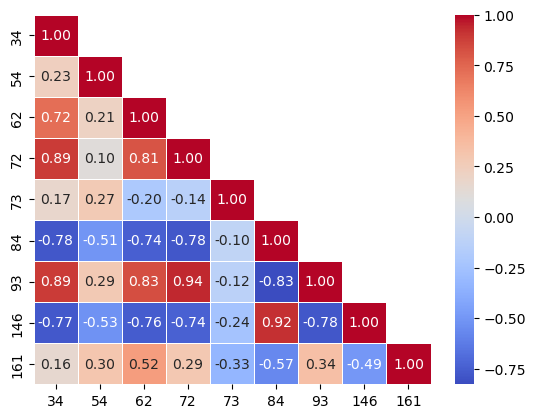

In [72]:
from seaborn import heatmap

# to store close prices
close_df = pd.DataFrame()

for stock in trader_A_stocks:
    close_df[stock] = trader_A_performance_dict[stock]['daily pnl df']['close']
    
corr = close_df.corr()
matrix = np.triu(corr) - np.eye(len(corr))    # only traingular

heatmap(corr, annot = True, mask = matrix, cmap = 'coolwarm', linewidth = 0.5, fmt = '.2f');

##### `Random interesting observations`

There are $500$ instruments but we only have data for $50$.

In [73]:
instruments = theoretical_prices_df.index.get_level_values(0).unique()
print(f'Number of instruments = {len(instruments)}')
instruments

Number of instruments = 50


Int64Index([  2,  18,  24,  34,  54,  62,  72,  73,  84,  93, 146, 161, 184,
            190, 195, 214, 218, 231, 237, 239, 264, 266, 275, 292, 299, 317,
            318, 320, 326, 327, 329, 334, 336, 343, 346, 368, 370, 384, 397,
            400, 407, 420, 442, 454, 457, 461, 469, 472, 488, 489],
           dtype='int64', name='instrument_id')

A Russian (RU) stock (currency `Rubles, RUB`) had a `2:1` split.

In [74]:
instruments_df = instruments_df.loc[instruments]
instruments_df.loc[instruments_df['currency'] == 'RUB']

index   mic          isin currency ticker           name  \
instrument_id                                                             
327              327  XQTX  US48122U2042      RUB   KO71  Sistema PJSFC   

              country industry_subgroup  
instrument_id                            
327                RU  Telecom Services

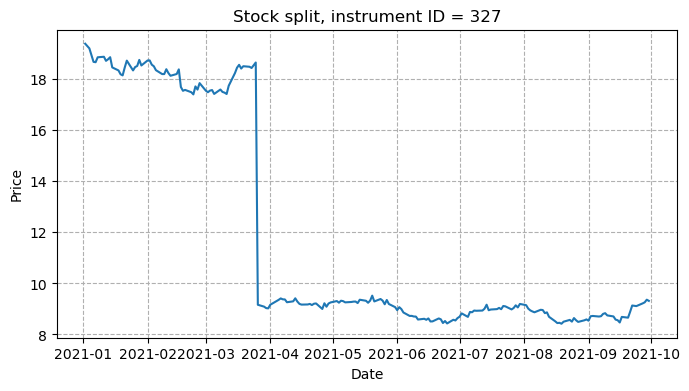

In [75]:
plt.figure(figsize = (8, 4))
plt.title('Stock split, instrument ID = 327')
plt.ylabel('Price')
plt.xlabel('Date')
plt.plot(get_pnl_data(327)[0]['close'])
plt.grid(True, linestyle = '--');

<a id='glossary'></a>
# 9. `Glossary`
---
> ## _Instrument definition details_
> _We provide the details of the instrument definitions below._

1. **instrument_id**  
The id of the instrument
1. **mic**  
The market identification code. This code uniquely specifies the market at which the instrument is being traded. See for more details https://www.iso20022.org/market-identifier-codes
1. **isin**  
This is the International Security Identification Number (ISIN) of the instrument. It is a unique code that identifies the share of the company. See for more details https://www.isin.org.
1. **currency**  
This is the three-letter currency ISO code in which the instrument is being traded. See for details https://www.iso.org/iso-4217-currency-codes.html
1. **ticker**  
This is a short -- often human readable code -- for the instrument and where it is traded.
1. **name**  
This is the name of the company. Often it includes the share class.
1. **country**  
This is the two-letter ISO country code. See for more details https://www.iso.org/iso-3166-country-codes.html
1. **industry_subgroup**  
This is the lowest level industry classification details from the Bloomberg Industry Classification System that is similar to the Global Industry Classification System (GICS) used for the construction of MSCI indices globally. See for details on GICS https://www.msci.com/our-solutions/indexes/gics and https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard   

----